In [75]:
import pandas as pd
import pypsa
import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [76]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime

# load onshore wind data
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)

# load offshore wind data
df_offshorewind = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshorewind.index = pd.to_datetime(df_offshorewind.index)

# load large scale pv data
df_pv = pd.read_csv('data\pv_optimal.csv', sep=';', index_col=0)
df_pv.index = pd.to_datetime(df_pv.index)

# load rooftop pv data
df_rooftop = pd.read_csv('data\pv_rooftop.csv', sep=';', index_col=0)
df_rooftop.index = pd.to_datetime(df_rooftop.index)

# load hydro inflow in Austria
df_hydro = pd.read_csv('data/Hydro_Inflow_AT.csv')  # assumes columns: Year, Month, Day, Inflow [GWh]
df_hydro['date'] = pd.to_datetime(df_hydro[['Year', 'Month', 'Day']])
df_hydro.set_index('date', inplace=True)

# Convert from GWh/day → MW (spread evenly across 24 hours)
df_hydro['inflow_MW'] = df_hydro['Inflow [GWh]'] * 1000 / 24
## Align to model snapshots
df_hydro_hourly = df_hydro['inflow_MW'].resample('H').ffill()


hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

df_hydro_inflow = pd.DataFrame(index=hours_in_2015)
df_hydro_inflow['inflow_MW'] = df_hydro_hourly.loc[df_hydro_hourly.index.year==2011].values

<>:14: DeprecationWarning: invalid escape sequence '\p'
<>:18: DeprecationWarning: invalid escape sequence '\p'
<>:14: DeprecationWarning: invalid escape sequence '\p'
<>:18: DeprecationWarning: invalid escape sequence '\p'
C:\Users\alexk\AppData\Local\Temp\ipykernel_9516\3096401804.py:14: DeprecationWarning: invalid escape sequence '\p'
  df_pv = pd.read_csv('data\pv_optimal.csv', sep=';', index_col=0)
C:\Users\alexk\AppData\Local\Temp\ipykernel_9516\3096401804.py:18: DeprecationWarning: invalid escape sequence '\p'
  df_rooftop = pd.read_csv('data\pv_rooftop.csv', sep=';', index_col=0)
C:\Users\alexk\AppData\Local\Temp\ipykernel_9516\3096401804.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hydro_hourly = df_hydro['inflow_MW'].resample('H').ffill()


In [77]:
colors = {"onshore": "blue", "offshore": "darkblue", "pv": "orange", 
          "rooftop": "yellow", "coal": "brown", "OCGT": "grey"}

# __F.__ Make Network

In [78]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [79]:
n = pypsa.Network()
n.set_snapshots(hours_in_2015.values)

# add the different carriers, only gas emits CO2
n.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
n.add("Carrier", "coal", co2_emissions=0.9) # in t_CO2/MWh_th
n.add("Carrier", "onshorewind")
n.add("Carrier", "offshorewind")
n.add("Carrier", "solarPV")
n.add("Carrier", "rooftopPV")
n.add("Carrier", "hydro")

countries = ['DEU', 'DNK', 'AUT']
coordinates = {'DNK': (55.67, 12.57), # Copenhagen
                'DEU': (52.37, 9.73), # Hannover
                'AUT': (47.57, 14.23)} # Liezen

# add electricity bus
for country in countries:
    n.add("Bus",
                country,
                y = coordinates[country][0],
                x = coordinates[country][1],
                carrier="AC",)

    # add load to the bus
    n.add("Load",
                f"load{country}",
                bus=country,
                p_set=df_elec[country].values)


    ''' Add renewable generators '''
    if country != 'AUT':
        # Add onshore wind
        CF_wind_onshore = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
        lifetime = 30 # years
        discount_rate = 0.07 # 7%
        capex = 910000 # in €/MW
        fopex = 0.033 # 3.3% of capex
        capital_cost_onshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        n.add("Generator",
                    f"onshorewind{country}",
                    bus=country,
                    p_nom_extendable=True,
                    carrier="onshorewind",
                    #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                    capital_cost = capital_cost_onshorewind,
                    marginal_cost = 0,
                    p_max_pu = CF_wind_onshore.values)

        # Add offshore wind
        CF_wind_offshore = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
        lifetime = 25 # years
        discount_rate = 0.07 # 7%
        capex = 2506000 # in €/MW
        fopex = 0.03 # 3% of capex
        capital_cost_offshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        n.add("Generator",
                    f"offshorewind{country}",
                    bus=country,
                    p_nom_extendable=True,
                    carrier="offshorewind",
                    #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                    capital_cost = capital_cost_offshorewind,
                    marginal_cost = 0,
                    p_max_pu = CF_wind_offshore.values)

    # Add large scale solar
    CF_solar = df_pv[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    lifetime = 25 # years
    discount_rate = 0.07 # 7%
    capex = 425000 # in €/MW
    fopex = 0.03 # 3% of capex
    capital_cost_pv = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
    n.add("Generator",
                f"PV{country}",
                bus=country,
                p_nom_extendable=True,
                carrier="solarPV",
                #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                capital_cost = capital_cost_pv,
                marginal_cost = 0,
                p_max_pu = CF_solar.values)



    ''' Add non-renewables generators '''
    # add OCGT (Open Cycle Gas Turbine) generator
    lifetime = 25 # years
    discount_rate = 0.07 # 7%
    capex = 560000 # in €/MW
    fopex = 0.033 # 3.3% of capex
    capital_cost_OCGT = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
    fuel_cost = 21.6 # in €/MWh_th
    efficiency = 0.39 # MWh_elec/MWh_th
    marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
    n.add("Generator",
                f"OCGT{country}",
                bus=country,
                p_nom_extendable=True,
                carrier="gas",
                #p_nom_max=1000,
                capital_cost = capital_cost_OCGT,
                efficiency = efficiency,
                marginal_cost = marginal_cost_OCGT)

    if country == 'DEU':
        # add coal generator (without CCS) # https://atb-archive.nrel.gov/electricity/2018/index.html?t=cc
        lifetime = 25 # years
        discount_rate = 0.07 # 7%
        capex = 3294000 # in €/MW
        fopex = 0.03 # 3% of capex
        capital_cost_coal = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        fuel_cost = 4 # in €/MWh_th 
        efficiency = 0.36 # MWh_elec/MWh_th
        marginal_cost_coal = fuel_cost/efficiency # in €/MWh_el
        n.add("Generator",
                    f"coal{country}",
                    bus=country,
                    p_nom_extendable=True,
                    carrier="coal",
                    #p_nom_max=1000,
                    capital_cost = capital_cost_coal,
                    efficiency = efficiency,
                    marginal_cost = marginal_cost_coal)
        
    if country == 'AUT':
        lifetime = 80 # years
        discount_rate = 0.07 # 7%
        capex = 300000 # in €/MW
        fopex = 0.02 # 2% of capex
        capital_cost_hydro = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        marginal_cost_hydro = 0

        n.add("StorageUnit",
            name=f"hydro{country}",
            bus=country,
            p_nom_extendable=True,
            capital_cost=capital_cost_hydro,
            marginal_cost=0,
            efficiency_store=1.0,       # inflow enters fully
            efficiency_dispatch=0.9,    # turbine efficiency
            max_hours=500,             # max energy storage in MWh per MW of power capacity
            inflow=df_hydro_inflow.values.flatten(),  # energy inflow time series in MW
            carrier="hydro")


    # Add storage unit
    n.add("StorageUnit",
                f"battery{country}",
                bus=country,
                p_nom_extendable=True,
                capital_cost=12894+24678,
                efficiency_dispatch=0.96,
                efficiency_store=0.96,
                max_hours=12,
                cyclic_state_of_charge=True)
    




In [80]:
# Add AC lines between the countries
distances = {
    ("DEU", "DNK"): 406, # km
    ("DEU", "AUT"): 622, # km
    ("DNK", "AUT"): 909, # km
}

capital_cost_lines = 400 # in €/MW/km

n.add(
    "Line",
    "DEU-DNK",
    bus0="DEU",
    bus1="DNK",
    s_nom = 3650,
    x = 1,
    r = 1,
    #capital_cost = capital_cost_lines * distances[("DEU", "DNK")],
    #s_nom_extendable = True
)

n.add(
    "Line",
    "DEU-AUT",
    bus0="DEU",
    bus1="AUT",
    s_nom = 4900,
    x = 1,
    r = 1,
    #capital_cost = capital_cost_lines * distances[("DEU", "AUT")],
    #s_nom_extendable = True
)


Index(['DEU-AUT'], dtype='object')

In [81]:
n.lines

,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,
DEU-DNK,DEU,DNK,,1.0,1.0,0.0,0.0,3650.0,0.0,False,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DEU-AUT,DEU,AUT,,1.0,1.0,0.0,0.0,4900.0,0.0,False,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


c:\Users\alexk\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


(<matplotlib.collections.PatchCollection at 0x27b6174e4d0>,
 <matplotlib.collections.LineCollection at 0x27b262fce90>)

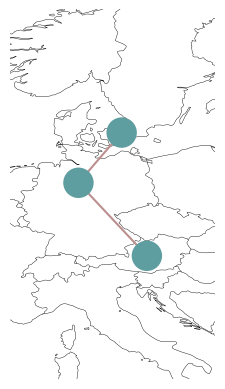

In [82]:
n.plot(bus_sizes=1, margin=1)

In [83]:

# Co2 Cap
CO2_limit = (152 + 4.9 + 6.0) #MtCO2 just electricity

n.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant= CO2_limit * 1000000, #152MtCO2 for GE + 6.0 for DK (https://www.nowtricity.com/country/denmark/) + 4.9 for AT (https://www.nowtricity.com/country/austria)
)


Index(['CO2Limit'], dtype='object')

In [84]:
n.optimize(solver_name='gurobi')


Index(['DEU', 'DNK', 'AUT'], dtype='object', name='Bus')


Index(['DEU-DNK', 'DEU-AUT'], dtype='object', name='Line')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 14.45it/s]
INFO:linopy.io: Writing time: 4.21s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-k3xp0it2.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-k3xp0it2.lp


Reading time = 1.31 seconds


INFO:gurobipy:Reading time = 1.31 seconds


obj: 499336 rows, 227775 columns, 1012000 nonzeros


INFO:gurobipy:obj: 499336 rows, 227775 columns, 1012000 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 499336 rows, 227775 columns and 1012000 nonzeros


INFO:gurobipy:Optimize a model with 499336 rows, 227775 columns and 1012000 nonzeros


Model fingerprint: 0xae47a983


INFO:gurobipy:Model fingerprint: 0xae47a983


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 5e+02]


INFO:gurobipy:  Matrix range     [1e-03, 5e+02]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [1e+03, 6e+03]


INFO:gurobipy:  Bounds range     [1e+03, 6e+03]


  RHS range        [1e+03, 2e+08]


INFO:gurobipy:  RHS range        [1e+03, 2e+08]


Presolve removed 249469 rows and 12934 columns


INFO:gurobipy:Presolve removed 249469 rows and 12934 columns


Presolve time: 0.88s


INFO:gurobipy:Presolve time: 0.88s


Presolved: 249867 rows, 214841 columns, 749597 nonzeros


INFO:gurobipy:Presolved: 249867 rows, 214841 columns, 749597 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.32s


INFO:gurobipy:Ordering time: 0.32s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 15


INFO:gurobipy: Dense cols : 15


 AA' NZ     : 6.311e+05


INFO:gurobipy: AA' NZ     : 6.311e+05


 Factor NZ  : 4.485e+06 (roughly 220 MB of memory)


INFO:gurobipy: Factor NZ  : 4.485e+06 (roughly 220 MB of memory)


 Factor Ops : 9.751e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 9.751e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.03522319e+13 -4.28241673e+11  5.21e+10 0.00e+00  4.60e+09     3s


INFO:gurobipy:   0   1.03522319e+13 -4.28241673e+11  5.21e+10 0.00e+00  4.60e+09     3s


   1   1.33670568e+13 -1.52673416e+12  1.00e+10 3.15e+02  1.04e+09     3s


INFO:gurobipy:   1   1.33670568e+13 -1.52673416e+12  1.00e+10 3.15e+02  1.04e+09     3s


   2   1.05880782e+13 -1.62656544e+12  1.25e+09 4.70e+01  1.72e+08     4s


INFO:gurobipy:   2   1.05880782e+13 -1.62656544e+12  1.25e+09 4.70e+01  1.72e+08     4s


   3   3.64597206e+12 -8.52063796e+11  1.18e+08 4.01e+00  2.17e+07     4s


INFO:gurobipy:   3   3.64597206e+12 -8.52063796e+11  1.18e+08 4.01e+00  2.17e+07     4s


   4   1.29455935e+12 -2.32550685e+11  2.72e+07 3.47e-01  4.41e+06     5s


INFO:gurobipy:   4   1.29455935e+12 -2.32550685e+11  2.72e+07 3.47e-01  4.41e+06     5s


   5   5.88916137e+11 -1.04588118e+11  1.05e+07 1.32e-01  1.83e+06     6s


INFO:gurobipy:   5   5.88916137e+11 -1.04588118e+11  1.05e+07 1.32e-01  1.83e+06     6s


   6   3.16613838e+11 -4.03132627e+10  5.00e+06 4.39e-02  8.94e+05     6s


INFO:gurobipy:   6   3.16613838e+11 -4.03132627e+10  5.00e+06 4.39e-02  8.94e+05     6s


   7   2.13693053e+11 -1.44564237e+10  3.16e+06 1.87e-02  5.58e+05     6s


INFO:gurobipy:   7   2.13693053e+11 -1.44564237e+10  3.16e+06 1.87e-02  5.58e+05     6s


   8   1.27615345e+11  9.85756826e+08  1.69e+06 8.22e-03  3.04e+05     7s


INFO:gurobipy:   8   1.27615345e+11  9.85756826e+08  1.69e+06 8.22e-03  3.04e+05     7s


   9   7.76106946e+10  1.06447311e+10  8.40e+05 2.90e-03  1.59e+05     7s


INFO:gurobipy:   9   7.76106946e+10  1.06447311e+10  8.40e+05 2.90e-03  1.59e+05     7s


  10   6.28053257e+10  1.51130301e+10  5.86e+05 1.11e-03  1.13e+05     8s


INFO:gurobipy:  10   6.28053257e+10  1.51130301e+10  5.86e+05 1.11e-03  1.13e+05     8s


  11   5.19843498e+10  1.85616991e+10  4.04e+05 2.64e-04  7.87e+04     8s


INFO:gurobipy:  11   5.19843498e+10  1.85616991e+10  4.04e+05 2.64e-04  7.87e+04     8s


  12   4.54495039e+10  2.19284010e+10  2.95e+05 7.57e-10  5.53e+04     9s


INFO:gurobipy:  12   4.54495039e+10  2.19284010e+10  2.95e+05 7.57e-10  5.53e+04     9s


  13   3.75416993e+10  2.37188399e+10  1.62e+05 3.84e-09  3.24e+04    10s


INFO:gurobipy:  13   3.75416993e+10  2.37188399e+10  1.62e+05 3.84e-09  3.24e+04    10s


  14   3.45511093e+10  2.53080668e+10  1.09e+05 3.46e-09  2.17e+04    11s


INFO:gurobipy:  14   3.45511093e+10  2.53080668e+10  1.09e+05 3.46e-09  2.17e+04    11s


  15   3.35349402e+10  2.58347838e+10  9.04e+04 2.36e-09  1.80e+04    11s


INFO:gurobipy:  15   3.35349402e+10  2.58347838e+10  9.04e+04 2.36e-09  1.80e+04    11s


  16   3.26153688e+10  2.66496444e+10  7.24e+04 3.41e-09  1.40e+04    12s


INFO:gurobipy:  16   3.26153688e+10  2.66496444e+10  7.24e+04 3.41e-09  1.40e+04    12s


  17   3.21011204e+10  2.69876711e+10  6.19e+04 2.44e-09  1.20e+04    12s


INFO:gurobipy:  17   3.21011204e+10  2.69876711e+10  6.19e+04 2.44e-09  1.20e+04    12s


  18   3.11856522e+10  2.75470675e+10  4.34e+04 9.18e-10  8.52e+03    13s


INFO:gurobipy:  18   3.11856522e+10  2.75470675e+10  4.34e+04 9.18e-10  8.52e+03    13s


  19   3.05422186e+10  2.80270435e+10  3.06e+04 2.06e-09  5.89e+03    13s


INFO:gurobipy:  19   3.05422186e+10  2.80270435e+10  3.06e+04 2.06e-09  5.89e+03    13s


  20   3.00784567e+10  2.82147961e+10  2.12e+04 6.73e-10  4.36e+03    14s


INFO:gurobipy:  20   3.00784567e+10  2.82147961e+10  2.12e+04 6.73e-10  4.36e+03    14s


  21   2.98733378e+10  2.83523559e+10  1.72e+04 8.84e-10  3.56e+03    15s


INFO:gurobipy:  21   2.98733378e+10  2.83523559e+10  1.72e+04 8.84e-10  3.56e+03    15s


  22   2.96184660e+10  2.85446399e+10  1.21e+04 9.02e-10  2.51e+03    15s


INFO:gurobipy:  22   2.96184660e+10  2.85446399e+10  1.21e+04 9.02e-10  2.51e+03    15s


  23   2.95046093e+10  2.86694383e+10  9.96e+03 1.74e-09  1.95e+03    16s


INFO:gurobipy:  23   2.95046093e+10  2.86694383e+10  9.96e+03 1.74e-09  1.95e+03    16s


  24   2.94124431e+10  2.87649555e+10  8.06e+03 1.48e-09  1.51e+03    17s


INFO:gurobipy:  24   2.94124431e+10  2.87649555e+10  8.06e+03 1.48e-09  1.51e+03    17s


  25   2.93073008e+10  2.87995315e+10  6.00e+03 1.35e-09  1.19e+03    17s


INFO:gurobipy:  25   2.93073008e+10  2.87995315e+10  6.00e+03 1.35e-09  1.19e+03    17s


  26   2.92644687e+10  2.88450344e+10  5.15e+03 1.25e-09  9.81e+02    18s


INFO:gurobipy:  26   2.92644687e+10  2.88450344e+10  5.15e+03 1.25e-09  9.81e+02    18s


  27   2.92548413e+10  2.88633484e+10  4.97e+03 3.01e-09  9.16e+02    19s


INFO:gurobipy:  27   2.92548413e+10  2.88633484e+10  4.97e+03 3.01e-09  9.16e+02    19s


  28   2.91882900e+10  2.89037039e+10  3.64e+03 1.98e-09  6.66e+02    19s


INFO:gurobipy:  28   2.91882900e+10  2.89037039e+10  3.64e+03 1.98e-09  6.66e+02    19s


  29   2.91566346e+10  2.89135954e+10  3.05e+03 2.64e-09  5.69e+02    20s


INFO:gurobipy:  29   2.91566346e+10  2.89135954e+10  3.05e+03 2.64e-09  5.69e+02    20s


  30   2.91311176e+10  2.89269611e+10  2.55e+03 2.74e-09  4.78e+02    21s


INFO:gurobipy:  30   2.91311176e+10  2.89269611e+10  2.55e+03 2.74e-09  4.78e+02    21s


  31   2.90891084e+10  2.89364718e+10  1.71e+03 4.84e-09  3.57e+02    22s


INFO:gurobipy:  31   2.90891084e+10  2.89364718e+10  1.71e+03 4.84e-09  3.57e+02    22s


  32   2.90733334e+10  2.89465164e+10  1.41e+03 3.23e-09  2.97e+02    22s


INFO:gurobipy:  32   2.90733334e+10  2.89465164e+10  1.41e+03 3.23e-09  2.97e+02    22s


  33   2.90664333e+10  2.89525880e+10  1.27e+03 2.78e-09  2.66e+02    23s


INFO:gurobipy:  33   2.90664333e+10  2.89525880e+10  1.27e+03 2.78e-09  2.66e+02    23s


  34   2.90556217e+10  2.89618758e+10  1.05e+03 6.18e-09  2.19e+02    24s


INFO:gurobipy:  34   2.90556217e+10  2.89618758e+10  1.05e+03 6.18e-09  2.19e+02    24s


  35   2.90525499e+10  2.89675267e+10  9.88e+02 9.01e-09  1.99e+02    24s


INFO:gurobipy:  35   2.90525499e+10  2.89675267e+10  9.88e+02 9.01e-09  1.99e+02    24s


  36   2.90454543e+10  2.89719267e+10  8.42e+02 8.37e-09  1.72e+02    25s


INFO:gurobipy:  36   2.90454543e+10  2.89719267e+10  8.42e+02 8.37e-09  1.72e+02    25s


  37   2.90382561e+10  2.89759630e+10  6.98e+02 9.94e-09  1.46e+02    26s


INFO:gurobipy:  37   2.90382561e+10  2.89759630e+10  6.98e+02 9.94e-09  1.46e+02    26s


  38   2.90333685e+10  2.89783376e+10  6.00e+02 1.03e-08  1.29e+02    26s


INFO:gurobipy:  38   2.90333685e+10  2.89783376e+10  6.00e+02 1.03e-08  1.29e+02    26s


  39   2.90274160e+10  2.89830625e+10  4.77e+02 2.65e-08  1.04e+02    27s


INFO:gurobipy:  39   2.90274160e+10  2.89830625e+10  4.77e+02 2.65e-08  1.04e+02    27s


  40   2.90238606e+10  2.89872228e+10  4.03e+02 3.61e-08  8.57e+01    28s


INFO:gurobipy:  40   2.90238606e+10  2.89872228e+10  4.03e+02 3.61e-08  8.57e+01    28s


  41   2.90208245e+10  2.89885642e+10  3.42e+02 4.45e-08  7.55e+01    28s


INFO:gurobipy:  41   2.90208245e+10  2.89885642e+10  3.42e+02 4.45e-08  7.55e+01    28s


  42   2.90173595e+10  2.89912795e+10  2.73e+02 4.26e-08  6.10e+01    29s


INFO:gurobipy:  42   2.90173595e+10  2.89912795e+10  2.73e+02 4.26e-08  6.10e+01    29s


  43   2.90165801e+10  2.89915977e+10  2.58e+02 4.45e-08  5.84e+01    29s


INFO:gurobipy:  43   2.90165801e+10  2.89915977e+10  2.58e+02 4.45e-08  5.84e+01    29s


  44   2.90142026e+10  2.89938728e+10  2.11e+02 4.18e-08  4.75e+01    30s


INFO:gurobipy:  44   2.90142026e+10  2.89938728e+10  2.11e+02 4.18e-08  4.75e+01    30s


  45   2.90127996e+10  2.89951836e+10  1.84e+02 5.63e-08  4.12e+01    31s


INFO:gurobipy:  45   2.90127996e+10  2.89951836e+10  1.84e+02 5.63e-08  4.12e+01    31s


  46   2.90123431e+10  2.89957011e+10  1.74e+02 5.30e-08  3.89e+01    31s


INFO:gurobipy:  46   2.90123431e+10  2.89957011e+10  1.74e+02 5.30e-08  3.89e+01    31s


  47   2.90113679e+10  2.89971817e+10  1.56e+02 2.92e-08  3.32e+01    32s


INFO:gurobipy:  47   2.90113679e+10  2.89971817e+10  1.56e+02 2.92e-08  3.32e+01    32s


  48   2.90091815e+10  2.89978025e+10  1.13e+02 2.68e-08  2.66e+01    33s


INFO:gurobipy:  48   2.90091815e+10  2.89978025e+10  1.13e+02 2.68e-08  2.66e+01    33s


  49   2.90086622e+10  2.89984792e+10  1.03e+02 2.01e-08  2.38e+01    33s


INFO:gurobipy:  49   2.90086622e+10  2.89984792e+10  1.03e+02 2.01e-08  2.38e+01    33s


  50   2.90085312e+10  2.89988659e+10  9.99e+01 2.39e-08  2.26e+01    34s


INFO:gurobipy:  50   2.90085312e+10  2.89988659e+10  9.99e+01 2.39e-08  2.26e+01    34s


  51   2.90069999e+10  2.89994919e+10  6.84e+01 2.12e-08  1.76e+01    35s


INFO:gurobipy:  51   2.90069999e+10  2.89994919e+10  6.84e+01 2.12e-08  1.76e+01    35s


  52   2.90060230e+10  2.89998401e+10  4.88e+01 1.96e-08  1.45e+01    35s


INFO:gurobipy:  52   2.90060230e+10  2.89998401e+10  4.88e+01 1.96e-08  1.45e+01    35s


  53   2.90057133e+10  2.90003275e+10  4.29e+01 9.12e-09  1.26e+01    36s


INFO:gurobipy:  53   2.90057133e+10  2.90003275e+10  4.29e+01 9.12e-09  1.26e+01    36s


  54   2.90054925e+10  2.90004759e+10  3.83e+01 1.62e-08  1.17e+01    37s


INFO:gurobipy:  54   2.90054925e+10  2.90004759e+10  3.83e+01 1.62e-08  1.17e+01    37s


  55   2.90049983e+10  2.90008801e+10  2.91e+01 4.14e-08  9.63e+00    37s


INFO:gurobipy:  55   2.90049983e+10  2.90008801e+10  2.91e+01 4.14e-08  9.63e+00    37s


  56   2.90048788e+10  2.90009687e+10  2.65e+01 4.28e-08  9.14e+00    38s


INFO:gurobipy:  56   2.90048788e+10  2.90009687e+10  2.65e+01 4.28e-08  9.14e+00    38s


  57   2.90043274e+10  2.90012779e+10  1.51e+01 3.82e-08  7.13e+00    39s


INFO:gurobipy:  57   2.90043274e+10  2.90012779e+10  1.51e+01 3.82e-08  7.13e+00    39s


  58   2.90042785e+10  2.90014936e+10  1.42e+01 3.21e-08  6.51e+00    39s


INFO:gurobipy:  58   2.90042785e+10  2.90014936e+10  1.42e+01 3.21e-08  6.51e+00    39s


  59   2.90040223e+10  2.90023289e+10  9.12e+00 2.77e-08  3.96e+00    40s


INFO:gurobipy:  59   2.90040223e+10  2.90023289e+10  9.12e+00 2.77e-08  3.96e+00    40s


  60   2.90038671e+10  2.90024493e+10  6.09e+00 2.55e-08  3.31e+00    40s


INFO:gurobipy:  60   2.90038671e+10  2.90024493e+10  6.09e+00 2.55e-08  3.31e+00    40s


  61   2.90037820e+10  2.90032671e+10  4.36e+00 3.03e-09  1.20e+00    41s


INFO:gurobipy:  61   2.90037820e+10  2.90032671e+10  4.36e+00 3.03e-09  1.20e+00    41s


  62   2.90036166e+10  2.90033693e+10  1.43e+00 1.77e-09  5.78e-01    42s


INFO:gurobipy:  62   2.90036166e+10  2.90033693e+10  1.43e+00 1.77e-09  5.78e-01    42s


  63   2.90035664e+10  2.90034727e+10  4.48e-01 1.17e-09  2.19e-01    42s


INFO:gurobipy:  63   2.90035664e+10  2.90034727e+10  4.48e-01 1.17e-09  2.19e-01    42s


  64   2.90035375e+10  2.90034896e+10  4.01e-03 6.76e-10  1.12e-01    43s


INFO:gurobipy:  64   2.90035375e+10  2.90034896e+10  4.01e-03 6.76e-10  1.12e-01    43s


  65   2.90035368e+10  2.90035315e+10  1.97e-03 6.03e-07  1.24e-02    43s


INFO:gurobipy:  65   2.90035368e+10  2.90035315e+10  1.97e-03 6.03e-07  1.24e-02    43s


  66   2.90035346e+10  2.90035344e+10  5.73e-05 9.74e-09  3.52e-04    43s


INFO:gurobipy:  66   2.90035346e+10  2.90035344e+10  5.73e-05 9.74e-09  3.52e-04    43s


  67   2.90035345e+10  2.90035345e+10  9.96e-05 1.04e-09  1.24e-04    44s


INFO:gurobipy:  67   2.90035345e+10  2.90035345e+10  9.96e-05 1.04e-09  1.24e-04    44s


  68   2.90035345e+10  2.90035345e+10  2.58e-05 5.04e-09  9.98e-06    45s


INFO:gurobipy:  68   2.90035345e+10  2.90035345e+10  2.58e-05 5.04e-09  9.98e-06    45s


  69   2.90035345e+10  2.90035345e+10  2.51e-08 7.71e-09  9.33e-09    45s


INFO:gurobipy:  69   2.90035345e+10  2.90035345e+10  2.51e-08 7.71e-09  9.33e-09    45s


INFO:gurobipy:


Barrier solved model in 69 iterations and 45.10 seconds (10.93 work units)


INFO:gurobipy:Barrier solved model in 69 iterations and 45.10 seconds (10.93 work units)


Optimal objective 2.90035345e+10


INFO:gurobipy:Optimal objective 2.90035345e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   61450 DPushes remaining with DInf 0.0000000e+00                45s


INFO:gurobipy:   61450 DPushes remaining with DInf 0.0000000e+00                45s


       0 DPushes remaining with DInf 0.0000000e+00                47s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                47s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   23685 PPushes remaining with PInf 0.0000000e+00                47s


INFO:gurobipy:   23685 PPushes remaining with PInf 0.0000000e+00                47s


   20010 PPushes remaining with PInf 0.0000000e+00                56s


INFO:gurobipy:   20010 PPushes remaining with PInf 0.0000000e+00                56s


   17355 PPushes remaining with PInf 0.0000000e+00                60s


INFO:gurobipy:   17355 PPushes remaining with PInf 0.0000000e+00                60s


   15657 PPushes remaining with PInf 0.0000000e+00                66s


INFO:gurobipy:   15657 PPushes remaining with PInf 0.0000000e+00                66s


   14374 PPushes remaining with PInf 0.0000000e+00                70s


INFO:gurobipy:   14374 PPushes remaining with PInf 0.0000000e+00                70s


   12782 PPushes remaining with PInf 0.0000000e+00                76s


INFO:gurobipy:   12782 PPushes remaining with PInf 0.0000000e+00                76s


   11222 PPushes remaining with PInf 0.0000000e+00                81s


INFO:gurobipy:   11222 PPushes remaining with PInf 0.0000000e+00                81s


   10029 PPushes remaining with PInf 0.0000000e+00                85s


INFO:gurobipy:   10029 PPushes remaining with PInf 0.0000000e+00                85s


    8432 PPushes remaining with PInf 0.0000000e+00                91s


INFO:gurobipy:    8432 PPushes remaining with PInf 0.0000000e+00                91s


    7074 PPushes remaining with PInf 0.0000000e+00                96s


INFO:gurobipy:    7074 PPushes remaining with PInf 0.0000000e+00                96s


    5993 PPushes remaining with PInf 0.0000000e+00               100s


INFO:gurobipy:    5993 PPushes remaining with PInf 0.0000000e+00               100s


    4641 PPushes remaining with PInf 0.0000000e+00               106s


INFO:gurobipy:    4641 PPushes remaining with PInf 0.0000000e+00               106s


    3285 PPushes remaining with PInf 0.0000000e+00               110s


INFO:gurobipy:    3285 PPushes remaining with PInf 0.0000000e+00               110s


    1662 PPushes remaining with PInf 0.0000000e+00               115s


INFO:gurobipy:    1662 PPushes remaining with PInf 0.0000000e+00               115s


     306 PPushes remaining with PInf 0.0000000e+00               120s


INFO:gurobipy:     306 PPushes remaining with PInf 0.0000000e+00               120s


       0 PPushes remaining with PInf 0.0000000e+00               122s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               122s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0782406e-08    122s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0782406e-08    122s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 2


INFO:gurobipy:Extra simplex iterations after uncrush: 2


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   56354    2.9003534e+10   0.000000e+00   0.000000e+00    123s


INFO:gurobipy:   56354    2.9003534e+10   0.000000e+00   0.000000e+00    123s


INFO:gurobipy:


Solved in 56354 iterations and 123.44 seconds (73.39 work units)


INFO:gurobipy:Solved in 56354 iterations and 123.44 seconds (73.39 work units)


Optimal objective  2.900353449e+10


INFO:gurobipy:Optimal objective  2.900353449e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 227775 primals, 499336 duals
Objective: 2.90e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-fix-s-lower, Line-fix-s-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [85]:
colors

{'onshore': 'blue',
 'offshore': 'darkblue',
 'pv': 'orange',
 'rooftop': 'yellow',
 'coal': 'brown',
 'OCGT': 'grey'}

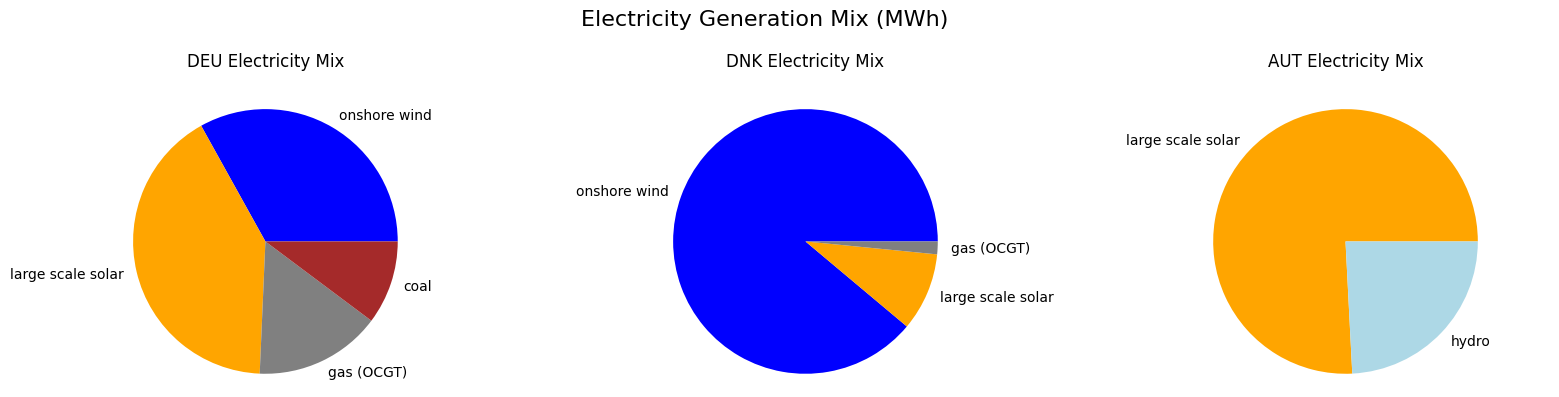

In [86]:
colors_gen = {
    'onshore wind': 'blue',
    'offshore wind': 'darkblue',
    'large scale solar': 'orange',
    'gas (OCGT)': 'grey',
    'coal': 'brown',
    'hydro': 'lightblue'
}

plt.figure(figsize=(16, 4))

for i, country in enumerate(countries):
    labels = []
    sizes = []

    # Onshore wind
    if f'onshorewind{country}' in n.generators.index:
        value = n.generators_t.p[f'onshorewind{country}'].sum()
        if value > 0.1:
            labels.append('onshore wind')
            sizes.append(value)

    # Offshore wind
    if f'offshorewind{country}' in n.generators.index:
        value = n.generators_t.p[f'offshorewind{country}'].sum()
        if value > 0.1:
            labels.append('offshore wind')
            sizes.append(value)

    # PV
    if f'PV{country}' in n.generators.index:
        value = n.generators_t.p[f'PV{country}'].sum()
        if value > 0.1:
            labels.append('large scale solar')
            sizes.append(value)

    # OCGT
    if f'OCGT{country}' in n.generators.index:
        value = n.generators_t.p[f'OCGT{country}'].sum()
        if value > 0.1:
            labels.append('gas (OCGT)')
            sizes.append(value)

    # Coal
    if f'coal{country}' in n.generators.index:
        value = n.generators_t.p[f'coal{country}'].sum()
        if value > 0.1:
            labels.append('coal')
            sizes.append(value)

    # Hydro (storage unit dispatch)
    if f"hydro{country}" in n.storage_units.index:
        value = n.storage_units_t.p[f"hydro{country}"].sum()
        if value > 0.1:
            labels.append('hydro')
            sizes.append(value)

    if sizes:
        colors = [colors_gen[label] for label in labels]
        plt.subplot(1, 3, i + 1)
        plt.pie(sizes, labels=labels, colors=colors, wedgeprops={'linewidth': 0})
        plt.axis('equal')
        plt.title(f"{country} Electricity Mix", y=1.07)
    else:
        plt.subplot(1, 3, i + 1)
        plt.text(0.5, 0.5, 'No generation', ha='center', va='center')
        plt.axis('off')

plt.suptitle("Electricity Generation Mix (MWh)", fontsize=16)
plt.tight_layout()
plt.show()


<AxesSubplot: xlabel='snapshot'>

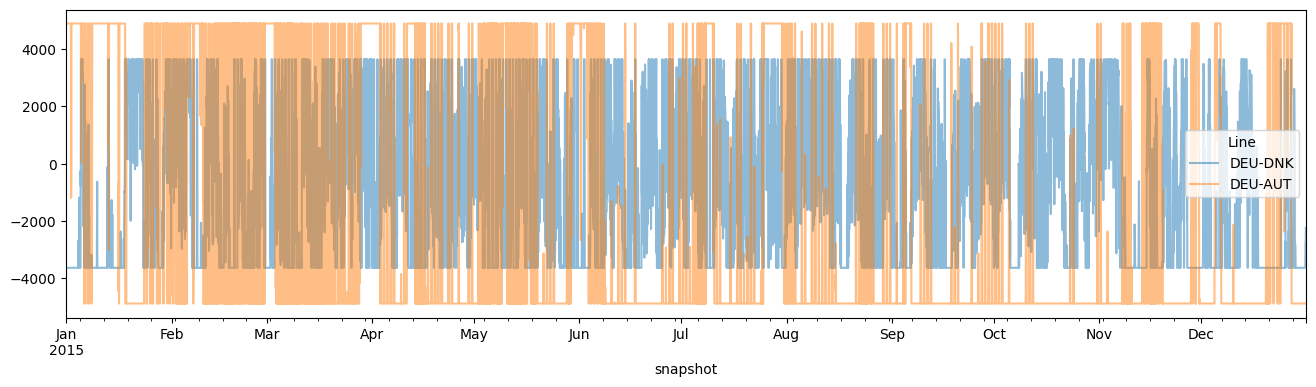

In [87]:
n.lines_t.p0.plot(figsize=(16, 4), alpha=0.5)

<AxesSubplot: xlabel='snapshot', ylabel='dispatch'>

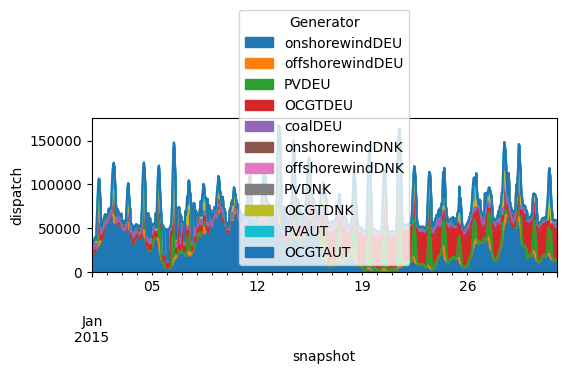

In [88]:
n.generators_t.p.loc["2015-01"].plot.area(figsize=(6, 2), ylabel="dispatch")

# Section G: Connecting to Heating sector

In [89]:
# Retrieve the heating demand data
heating_demand = pd.read_csv('data/heat_demand.csv', sep=';', index_col=0) # in MWh
heating_demand.index = pd.to_datetime(heating_demand.index) #change index to datatime


In [90]:
for country in countries:
      # add heat bus for each country
      n.add("Bus", f"{country}_heat", carrier="heat")

      # add heat load to the bus for each country
      n.add("Load",
            f"heat_load_{country}",
            bus=f"{country}_heat",
            p_set=heating_demand[country].values)

      # Add heat pump, assuming fixed COP. Would be nice to have a variable COP, but require temperature data for each country
      fixed_cop = 3 # Reasonable average for the chosen countries


      lifetime = 20 # years
      discount_rate = 0.07 # 7%
      capex = 933000 # in €/MW
      fopex = 0.035 # 3.5% of capex
      capital_cost_HP = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
      n.add("Link",
            f"heat_pump_{country}",
            bus0=country,              # electricity input
            bus1=f"{country}_heat",    # heat output
            efficiency=fixed_cop,
            p_nom_extendable=True,
            carrier="heat pump",
            capital_cost= capital_cost_HP
            )
      

      # Add CHP unit.
      lifetime = 25 # years
      discount_rate = 0.07 # 7%
      capex = 600000 # in €/MW
      fopex = 0.03 # 3% of capex
      capital_cost_CHP = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
      fuel_cost = 21.6 # in €/MWh_th
      efficiency = 0.47 # MWh_elec/MWh_th
      marginal_cost_CHP = fuel_cost/efficiency # in €/MWh_el
      n.add("Link",
            f"CHP_{country}",
            bus0="gas",                # gas input
            bus1=country,              # electricity output
            bus2=f"{country}_heat",    # heat output
            efficiency=efficiency,            # electric efficiency
            efficiency2=efficiency,           # heat efficiency
            p_nom_extendable=True,
            carrier="CHP",
            capital_cost= capital_cost_CHP,
            marginal_cost=marginal_cost_CHP) # in €/MWh_el
      

      # Add gas boiler
      lifetime = 20 # years
      discount_rate = 0.07 # 7%
      capex = 63*1000 # in €/MW
      fopex = 0.015 # 1.5% of capex
      capital_cost_boiler = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
      fuel_cost = 21.6 # in €/MWh_th
      efficiency = 0.9 # MWh_elec/MWh_th
      marginal_cost_boiler = fuel_cost/efficiency # in €/MWh_el
      n.add("Link",
            f"boiler_{country}",
            bus0="gas",                # gas input
            bus1=f"{country}_heat",    # heat output
            efficiency=efficiency,            # electric efficiency
            p_nom_extendable=True,
            carrier="boiler",
            capital_cost= capital_cost_boiler,
            marginal_cost=marginal_cost_boiler) # in €/MWh_el
      
      # Add resistive heater
      lifetime = 20 # years
      discount_rate = 0.07 # 7%
      capex = 100000 # in €/MW
      fopex = 0.02 # 2% of capex
      capital_cost_resistive = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
      marginal_cost_resistive = 0 # in €/MWh_el
      n.add("Link",
            f"resistive_{country}",
            bus0=country,              # electricity input
            bus1=f"{country}_heat",    # heat output
            efficiency=1,             # electric efficiency
            p_nom_extendable=True,
            carrier="resistive heater",
            capital_cost= capital_cost_resistive,
            marginal_cost=marginal_cost_resistive) # in €/MWh_el

Index(['CHP_DEU'], dtype='object')
Index(['boiler_DEU'], dtype='object')
Index(['CHP_DNK'], dtype='object')
Index(['boiler_DNK'], dtype='object')
Index(['CHP_AUT'], dtype='object')
Index(['boiler_AUT'], dtype='object')


In [91]:
# Add a gas bus
n.add("Bus", "gas", carrier="gas")


# Add a gas store
n.add("Store",
      "gas_store",
      bus="gas",
      e_nom=1e9,  # Very large nominal energy [MWh], to simulate unlimited gas
      e_initial=1e9,
      e_cyclic=True,
      marginal_cost=0)  # Assume gas availability (fuel cost is inside marginal_cost of generators)

# Add a generator that allows gas to enter the system
n.add("Generator",
      "gas_supply",
      bus="gas",
      carrier="gas",
      p_nom=1e6,  # large enough to never limit
      marginal_cost=0)  # or set = 21.6 €/MWh_th if not already in OCGT/CHP costs


Index(['gas_supply'], dtype='object')

In [92]:
n.optimize(solver_name='gurobi')


Index(['DEU', 'DNK', 'AUT', 'DEU_heat', 'DNK_heat', 'AUT_heat'], dtype='object', name='Bus')


Index(['heat_pump_DEU', 'CHP_DEU', 'boiler_DEU', 'resistive_DEU',
       'heat_pump_DNK', 'CHP_DNK', 'boiler_DNK', 'resistive_DNK',
       'heat_pump_AUT', 'CHP_AUT', 'boiler_AUT', 'resistive_AUT'],
      dtype='object', name='Link')
Index(['DEU-DNK', 'DEU-AUT'], dtype='object', name='Line')
Index(['0'], dtype='object', name='SubNetwork')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 12/12 [00:00<00:00, 12.05it/s]
INFO:linopy.io: Writing time: 6.76s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-yb4qgwrs.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-yb4qgwrs.lp


Reading time = 2.21 seconds


INFO:gurobipy:Reading time = 2.21 seconds


obj: 788428 rows, 359187 columns, 1651492 nonzeros


INFO:gurobipy:obj: 788428 rows, 359187 columns, 1651492 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 788428 rows, 359187 columns and 1651492 nonzeros


INFO:gurobipy:Optimize a model with 788428 rows, 359187 columns and 1651492 nonzeros


Model fingerprint: 0x08b6163b


INFO:gurobipy:Model fingerprint: 0x08b6163b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 5e+02]


INFO:gurobipy:  Matrix range     [1e-03, 5e+02]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [1e+03, 6e+03]


INFO:gurobipy:  Bounds range     [1e+03, 6e+03]


  RHS range        [1e+03, 1e+09]


INFO:gurobipy:  RHS range        [1e+03, 1e+09]


Presolve removed 398401 rows and 21694 columns


INFO:gurobipy:Presolve removed 398401 rows and 21694 columns


Presolve time: 1.42s


INFO:gurobipy:Presolve time: 1.42s


Presolved: 390027 rows, 337493 columns, 1231397 nonzeros


INFO:gurobipy:Presolved: 390027 rows, 337493 columns, 1231397 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 1.18s


INFO:gurobipy:Ordering time: 1.18s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 27


INFO:gurobipy: Dense cols : 27


 AA' NZ     : 1.069e+06


INFO:gurobipy: AA' NZ     : 1.069e+06


 Factor NZ  : 5.793e+06 (roughly 340 MB of memory)


INFO:gurobipy: Factor NZ  : 5.793e+06 (roughly 340 MB of memory)


 Factor Ops : 1.390e+08 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.390e+08 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.80572626e+13 -1.61307661e+15  8.92e+10 0.00e+00  3.46e+09     5s


INFO:gurobipy:   0   3.80572626e+13 -1.61307661e+15  8.92e+10 0.00e+00  3.46e+09     5s


   1   2.61605128e+13 -5.31665798e+14  2.20e+10 5.83e+01  1.11e+09     5s


INFO:gurobipy:   1   2.61605128e+13 -5.31665798e+14  2.20e+10 5.83e+01  1.11e+09     5s


   2   1.29311812e+13 -5.92721552e+13  2.24e+09 6.22e+00  1.33e+08     6s


INFO:gurobipy:   2   1.29311812e+13 -5.92721552e+13  2.24e+09 6.22e+00  1.33e+08     6s


   3   4.85572347e+12 -9.07998555e+12  3.82e+08 8.79e-01  2.30e+07     7s


INFO:gurobipy:   3   4.85572347e+12 -9.07998555e+12  3.82e+08 8.79e-01  2.30e+07     7s


   4   3.05492699e+12 -1.75647332e+12  2.03e+08 1.51e-01  7.48e+06     8s


INFO:gurobipy:   4   3.05492699e+12 -1.75647332e+12  2.03e+08 1.51e-01  7.48e+06     8s


   5   1.17893144e+12 -4.82970968e+11  7.05e+07 3.41e-02  2.42e+06     9s


INFO:gurobipy:   5   1.17893144e+12 -4.82970968e+11  7.05e+07 3.41e-02  2.42e+06     9s


   6   5.59865534e+11 -1.75230762e+11  3.04e+07 7.71e-03  1.03e+06    10s


INFO:gurobipy:   6   5.59865534e+11 -1.75230762e+11  3.04e+07 7.71e-03  1.03e+06    10s


   7   2.85537980e+11 -5.42233143e+10  1.34e+07 1.34e-03  4.62e+05    11s


INFO:gurobipy:   7   2.85537980e+11 -5.42233143e+10  1.34e+07 1.34e-03  4.62e+05    11s


   8   1.68425388e+11 -2.69052708e+10  6.39e+06 1.69e-04  2.61e+05    11s


INFO:gurobipy:   8   1.68425388e+11 -2.69052708e+10  6.39e+06 1.69e-04  2.61e+05    11s


   9   1.29748573e+11  1.20039170e+10  4.29e+06 1.06e-09  1.56e+05    12s


INFO:gurobipy:   9   1.29748573e+11  1.20039170e+10  4.29e+06 1.06e-09  1.56e+05    12s


  10   1.03175309e+11  2.45206424e+10  2.86e+06 7.35e-10  1.03e+05    13s


INFO:gurobipy:  10   1.03175309e+11  2.45206424e+10  2.86e+06 7.35e-10  1.03e+05    13s


  11   8.24837666e+10  3.14342201e+10  1.78e+06 6.84e-10  6.68e+04    14s


INFO:gurobipy:  11   8.24837666e+10  3.14342201e+10  1.78e+06 6.84e-10  6.68e+04    14s


  12   7.45872560e+10  3.64606166e+10  1.32e+06 5.18e-10  4.97e+04    14s


INFO:gurobipy:  12   7.45872560e+10  3.64606166e+10  1.32e+06 5.18e-10  4.97e+04    14s


  13   6.91069720e+10  4.00155391e+10  1.00e+06 4.09e-09  3.78e+04    15s


INFO:gurobipy:  13   6.91069720e+10  4.00155391e+10  1.00e+06 4.09e-09  3.78e+04    15s


  14   6.49648071e+10  4.28018502e+10  7.58e+05 4.05e-09  2.88e+04    16s


INFO:gurobipy:  14   6.49648071e+10  4.28018502e+10  7.58e+05 4.05e-09  2.88e+04    16s


  15   6.27705715e+10  4.47743735e+10  6.39e+05 9.52e-09  2.34e+04    17s


INFO:gurobipy:  15   6.27705715e+10  4.47743735e+10  6.39e+05 9.52e-09  2.34e+04    17s


  16   6.06444904e+10  4.66729745e+10  5.15e+05 2.86e-07  1.81e+04    18s


INFO:gurobipy:  16   6.06444904e+10  4.66729745e+10  5.15e+05 2.86e-07  1.81e+04    18s


  17   5.89683183e+10  4.80697015e+10  4.16e+05 8.10e-07  1.41e+04    19s


INFO:gurobipy:  17   5.89683183e+10  4.80697015e+10  4.16e+05 8.10e-07  1.41e+04    19s


  18   5.70011808e+10  4.88000959e+10  2.95e+05 1.23e-06  1.06e+04    20s


INFO:gurobipy:  18   5.70011808e+10  4.88000959e+10  2.95e+05 1.23e-06  1.06e+04    20s


  19   5.60684768e+10  4.93196046e+10  2.35e+05 1.50e-06  8.74e+03    21s


INFO:gurobipy:  19   5.60684768e+10  4.93196046e+10  2.35e+05 1.50e-06  8.74e+03    21s


  20   5.51844763e+10  5.00731481e+10  1.78e+05 1.82e-06  6.61e+03    22s


INFO:gurobipy:  20   5.51844763e+10  5.00731481e+10  1.78e+05 1.82e-06  6.61e+03    22s


  21   5.48419028e+10  5.06132645e+10  1.57e+05 2.04e-06  5.47e+03    23s


INFO:gurobipy:  21   5.48419028e+10  5.06132645e+10  1.57e+05 2.04e-06  5.47e+03    23s


  22   5.47383664e+10  5.06771631e+10  1.50e+05 2.04e-06  5.26e+03    23s


INFO:gurobipy:  22   5.47383664e+10  5.06771631e+10  1.50e+05 2.04e-06  5.26e+03    23s


  23   5.43636045e+10  5.08897693e+10  1.25e+05 2.11e-06  4.50e+03    24s


INFO:gurobipy:  23   5.43636045e+10  5.08897693e+10  1.25e+05 2.11e-06  4.50e+03    24s


  24   5.40190324e+10  5.11970125e+10  1.01e+05 2.16e-06  3.65e+03    25s


INFO:gurobipy:  24   5.40190324e+10  5.11970125e+10  1.01e+05 2.16e-06  3.65e+03    25s


  25   5.38024638e+10  5.14901169e+10  8.64e+04 2.23e-06  2.99e+03    26s


INFO:gurobipy:  25   5.38024638e+10  5.14901169e+10  8.64e+04 2.23e-06  2.99e+03    26s


  26   5.35925000e+10  5.16329909e+10  7.15e+04 2.22e-06  2.54e+03    27s


INFO:gurobipy:  26   5.35925000e+10  5.16329909e+10  7.15e+04 2.22e-06  2.54e+03    27s


  27   5.34626642e+10  5.18511965e+10  6.27e+04 2.10e-06  2.09e+03    28s


INFO:gurobipy:  27   5.34626642e+10  5.18511965e+10  6.27e+04 2.10e-06  2.09e+03    28s


  28   5.33247318e+10  5.19713219e+10  5.32e+04 2.03e-06  1.75e+03    29s


INFO:gurobipy:  28   5.33247318e+10  5.19713219e+10  5.32e+04 2.03e-06  1.75e+03    29s


  29   5.31864519e+10  5.20442005e+10  4.31e+04 1.92e-06  1.48e+03    30s


INFO:gurobipy:  29   5.31864519e+10  5.20442005e+10  4.31e+04 1.92e-06  1.48e+03    30s


  30   5.31575463e+10  5.20737104e+10  4.10e+04 1.86e-06  1.40e+03    31s


INFO:gurobipy:  30   5.31575463e+10  5.20737104e+10  4.10e+04 1.86e-06  1.40e+03    31s


  31   5.31323758e+10  5.21127820e+10  3.93e+04 1.77e-06  1.32e+03    32s


INFO:gurobipy:  31   5.31323758e+10  5.21127820e+10  3.93e+04 1.77e-06  1.32e+03    32s


  32   5.30847932e+10  5.22184992e+10  3.62e+04 1.54e-06  1.12e+03    32s


INFO:gurobipy:  32   5.30847932e+10  5.22184992e+10  3.62e+04 1.54e-06  1.12e+03    32s


  33   5.30028670e+10  5.22445684e+10  3.03e+04 1.46e-06  9.82e+02    33s


INFO:gurobipy:  33   5.30028670e+10  5.22445684e+10  3.03e+04 1.46e-06  9.82e+02    33s


  34   5.29530449e+10  5.22588896e+10  2.64e+04 1.42e-06  8.99e+02    34s


INFO:gurobipy:  34   5.29530449e+10  5.22588896e+10  2.64e+04 1.42e-06  8.99e+02    34s


  35   5.29107981e+10  5.23282291e+10  2.34e+04 1.20e-06  7.54e+02    35s


INFO:gurobipy:  35   5.29107981e+10  5.23282291e+10  2.34e+04 1.20e-06  7.54e+02    35s


  36   5.29033431e+10  5.23443434e+10  2.29e+04 1.16e-06  7.24e+02    35s


INFO:gurobipy:  36   5.29033431e+10  5.23443434e+10  2.29e+04 1.16e-06  7.24e+02    35s


  37   5.28805225e+10  5.23588640e+10  2.11e+04 1.12e-06  6.76e+02    36s


INFO:gurobipy:  37   5.28805225e+10  5.23588640e+10  2.11e+04 1.12e-06  6.76e+02    36s


  38   5.28509832e+10  5.23891769e+10  1.89e+04 1.04e-06  5.98e+02    37s


INFO:gurobipy:  38   5.28509832e+10  5.23891769e+10  1.89e+04 1.04e-06  5.98e+02    37s


  39   5.28272586e+10  5.24265896e+10  1.70e+04 9.13e-07  5.19e+02    38s


INFO:gurobipy:  39   5.28272586e+10  5.24265896e+10  1.70e+04 9.13e-07  5.19e+02    38s


  40   5.28075938e+10  5.24512476e+10  1.56e+04 8.23e-07  4.62e+02    39s


INFO:gurobipy:  40   5.28075938e+10  5.24512476e+10  1.56e+04 8.23e-07  4.62e+02    39s


  41   5.27851262e+10  5.24659996e+10  1.39e+04 7.72e-07  4.14e+02    40s


INFO:gurobipy:  41   5.27851262e+10  5.24659996e+10  1.39e+04 7.72e-07  4.14e+02    40s


  42   5.27746565e+10  5.24806780e+10  1.31e+04 7.12e-07  3.81e+02    41s


INFO:gurobipy:  42   5.27746565e+10  5.24806780e+10  1.31e+04 7.12e-07  3.81e+02    41s


  43   5.27569017e+10  5.24922068e+10  1.17e+04 6.59e-07  3.43e+02    42s


INFO:gurobipy:  43   5.27569017e+10  5.24922068e+10  1.17e+04 6.59e-07  3.43e+02    42s


  44   5.27476159e+10  5.25008237e+10  1.10e+04 6.18e-07  3.20e+02    42s


INFO:gurobipy:  44   5.27476159e+10  5.25008237e+10  1.10e+04 6.18e-07  3.20e+02    42s


  45   5.27330222e+10  5.25154240e+10  1.00e+04 5.54e-07  2.82e+02    43s


INFO:gurobipy:  45   5.27330222e+10  5.25154240e+10  1.00e+04 5.54e-07  2.82e+02    43s


  46   5.27127000e+10  5.25300420e+10  8.42e+03 4.85e-07  2.37e+02    44s


INFO:gurobipy:  46   5.27127000e+10  5.25300420e+10  8.42e+03 4.85e-07  2.37e+02    44s


  47   5.27005683e+10  5.25392548e+10  7.47e+03 4.37e-07  2.09e+02    45s


INFO:gurobipy:  47   5.27005683e+10  5.25392548e+10  7.47e+03 4.37e-07  2.09e+02    45s


  48   5.26937248e+10  5.25476184e+10  6.90e+03 3.94e-07  1.90e+02    45s


INFO:gurobipy:  48   5.26937248e+10  5.25476184e+10  6.90e+03 3.94e-07  1.90e+02    45s


  49   5.26906971e+10  5.25532488e+10  6.62e+03 3.63e-07  1.78e+02    46s


INFO:gurobipy:  49   5.26906971e+10  5.25532488e+10  6.62e+03 3.63e-07  1.78e+02    46s


  50   5.26817012e+10  5.25565647e+10  5.90e+03 3.42e-07  1.62e+02    47s


INFO:gurobipy:  50   5.26817012e+10  5.25565647e+10  5.90e+03 3.42e-07  1.62e+02    47s


  51   5.26735617e+10  5.25591811e+10  5.21e+03 3.27e-07  1.48e+02    47s


INFO:gurobipy:  51   5.26735617e+10  5.25591811e+10  5.21e+03 3.27e-07  1.48e+02    47s


  52   5.26664000e+10  5.25651864e+10  4.68e+03 2.92e-07  1.31e+02    48s


INFO:gurobipy:  52   5.26664000e+10  5.25651864e+10  4.68e+03 2.92e-07  1.31e+02    48s


  53   5.26601207e+10  5.25726075e+10  4.16e+03 2.51e-07  1.14e+02    49s


INFO:gurobipy:  53   5.26601207e+10  5.25726075e+10  4.16e+03 2.51e-07  1.14e+02    49s


  54   5.26542081e+10  5.25764106e+10  3.69e+03 2.30e-07  1.01e+02    50s


INFO:gurobipy:  54   5.26542081e+10  5.25764106e+10  3.69e+03 2.30e-07  1.01e+02    50s


  55   5.26454698e+10  5.25841757e+10  2.95e+03 1.88e-07  7.95e+01    50s


INFO:gurobipy:  55   5.26454698e+10  5.25841757e+10  2.95e+03 1.88e-07  7.95e+01    50s


  56   5.26437048e+10  5.25859286e+10  2.80e+03 1.77e-07  7.50e+01    51s


INFO:gurobipy:  56   5.26437048e+10  5.25859286e+10  2.80e+03 1.77e-07  7.50e+01    51s


  57   5.26372282e+10  5.25890795e+10  2.24e+03 1.58e-07  6.25e+01    52s


INFO:gurobipy:  57   5.26372282e+10  5.25890795e+10  2.24e+03 1.58e-07  6.25e+01    52s


  58   5.26351331e+10  5.25913894e+10  2.06e+03 1.43e-07  5.68e+01    52s


INFO:gurobipy:  58   5.26351331e+10  5.25913894e+10  2.06e+03 1.43e-07  5.68e+01    52s


  59   5.26304077e+10  5.25930018e+10  1.66e+03 1.32e-07  4.85e+01    53s


INFO:gurobipy:  59   5.26304077e+10  5.25930018e+10  1.66e+03 1.32e-07  4.85e+01    53s


  60   5.26269931e+10  5.25961868e+10  1.35e+03 1.11e-07  3.99e+01    54s


INFO:gurobipy:  60   5.26269931e+10  5.25961868e+10  1.35e+03 1.11e-07  3.99e+01    54s


  61   5.26257955e+10  5.25996342e+10  1.25e+03 8.67e-08  3.39e+01    55s


INFO:gurobipy:  61   5.26257955e+10  5.25996342e+10  1.25e+03 8.67e-08  3.39e+01    55s


  62   5.26245124e+10  5.26001812e+10  1.14e+03 8.34e-08  3.16e+01    55s


INFO:gurobipy:  62   5.26245124e+10  5.26001812e+10  1.14e+03 8.34e-08  3.16e+01    55s


  63   5.26216187e+10  5.26016549e+10  8.77e+02 7.28e-08  2.59e+01    56s


INFO:gurobipy:  63   5.26216187e+10  5.26016549e+10  8.77e+02 7.28e-08  2.59e+01    56s


  64   5.26197606e+10  5.26041000e+10  7.16e+02 5.58e-08  2.03e+01    56s


INFO:gurobipy:  64   5.26197606e+10  5.26041000e+10  7.16e+02 5.58e-08  2.03e+01    56s


  65   5.26175364e+10  5.26058830e+10  5.18e+02 5.44e-08  1.51e+01    57s


INFO:gurobipy:  65   5.26175364e+10  5.26058830e+10  5.18e+02 5.44e-08  1.51e+01    57s


  66   5.26165986e+10  5.26069741e+10  4.39e+02 4.05e-08  1.25e+01    58s


INFO:gurobipy:  66   5.26165986e+10  5.26069741e+10  4.39e+02 4.05e-08  1.25e+01    58s


  67   5.26151416e+10  5.26074161e+10  3.08e+02 3.29e-08  1.00e+01    58s


INFO:gurobipy:  67   5.26151416e+10  5.26074161e+10  3.08e+02 3.29e-08  1.00e+01    58s


  68   5.26142483e+10  5.26082504e+10  2.28e+02 2.56e-08  7.77e+00    59s


INFO:gurobipy:  68   5.26142483e+10  5.26082504e+10  2.28e+02 2.56e-08  7.77e+00    59s


  69   5.26134883e+10  5.26087212e+10  1.63e+02 2.24e-08  6.17e+00    60s


INFO:gurobipy:  69   5.26134883e+10  5.26087212e+10  1.63e+02 2.24e-08  6.17e+00    60s


  70   5.26127320e+10  5.26093324e+10  9.50e+01 1.80e-08  4.39e+00    60s


INFO:gurobipy:  70   5.26127320e+10  5.26093324e+10  9.50e+01 1.80e-08  4.39e+00    60s


  71   5.26122181e+10  5.26096327e+10  5.07e+01 1.62e-08  3.33e+00    61s


INFO:gurobipy:  71   5.26122181e+10  5.26096327e+10  5.07e+01 1.62e-08  3.33e+00    61s


  72   5.26120986e+10  5.26107908e+10  4.07e+01 2.06e-08  1.69e+00    62s


INFO:gurobipy:  72   5.26120986e+10  5.26107908e+10  4.07e+01 2.06e-08  1.69e+00    62s


  73   5.26119319e+10  5.26110282e+10  2.69e+01 1.42e-08  1.17e+00    63s


INFO:gurobipy:  73   5.26119319e+10  5.26110282e+10  2.69e+01 1.42e-08  1.17e+00    63s


  74   5.26118570e+10  5.26111437e+10  2.07e+01 1.15e-08  9.22e-01    63s


INFO:gurobipy:  74   5.26118570e+10  5.26111437e+10  2.07e+01 1.15e-08  9.22e-01    63s


  75   5.26117024e+10  5.26112321e+10  8.35e+00 1.34e-08  6.06e-01    64s


INFO:gurobipy:  75   5.26117024e+10  5.26112321e+10  8.35e+00 1.34e-08  6.06e-01    64s


  76   5.26116155e+10  5.26113905e+10  7.38e-01 8.81e-08  2.89e-01    65s


INFO:gurobipy:  76   5.26116155e+10  5.26113905e+10  7.38e-01 8.81e-08  2.89e-01    65s


  77   5.26116108e+10  5.26114567e+10  5.31e-01 1.01e-07  1.98e-01    66s


INFO:gurobipy:  77   5.26116108e+10  5.26114567e+10  5.31e-01 1.01e-07  1.98e-01    66s


  78   5.26116077e+10  5.26115008e+10  3.91e-01 1.13e-07  1.37e-01    66s


INFO:gurobipy:  78   5.26116077e+10  5.26115008e+10  3.91e-01 1.13e-07  1.37e-01    66s


  79   5.26116039e+10  5.26115217e+10  2.56e-01 1.32e-07  1.06e-01    67s


INFO:gurobipy:  79   5.26116039e+10  5.26115217e+10  2.56e-01 1.32e-07  1.06e-01    67s


  80   5.26116010e+10  5.26115661e+10  1.36e-01 3.46e-07  4.49e-02    67s


INFO:gurobipy:  80   5.26116010e+10  5.26115661e+10  1.36e-01 3.46e-07  4.49e-02    67s


  81   5.26115999e+10  5.26115751e+10  9.47e-02 2.47e-07  3.18e-02    68s


INFO:gurobipy:  81   5.26115999e+10  5.26115751e+10  9.47e-02 2.47e-07  3.18e-02    68s


  82   5.26115982e+10  5.26115869e+10  4.10e-02 3.60e-07  1.45e-02    68s


INFO:gurobipy:  82   5.26115982e+10  5.26115869e+10  4.10e-02 3.60e-07  1.45e-02    68s


  83   5.26115976e+10  5.26115922e+10  2.20e-02 1.18e-07  6.99e-03    69s


INFO:gurobipy:  83   5.26115976e+10  5.26115922e+10  2.20e-02 1.18e-07  6.99e-03    69s


  84   5.26115971e+10  5.26115951e+10  6.12e-03 1.08e-07  2.62e-03    69s


INFO:gurobipy:  84   5.26115971e+10  5.26115951e+10  6.12e-03 1.08e-07  2.62e-03    69s


  85   5.26115969e+10  5.26115962e+10  3.04e-04 6.12e-07  8.45e-04    70s


INFO:gurobipy:  85   5.26115969e+10  5.26115962e+10  3.04e-04 6.12e-07  8.45e-04    70s


  86   5.26115969e+10  5.26115967e+10  1.63e-04 1.55e-07  2.22e-04    70s


INFO:gurobipy:  86   5.26115969e+10  5.26115967e+10  1.63e-04 1.55e-07  2.22e-04    70s


  87   5.26115969e+10  5.26115969e+10  2.66e-05 4.68e-09  8.45e-07    71s


INFO:gurobipy:  87   5.26115969e+10  5.26115969e+10  2.66e-05 4.68e-09  8.45e-07    71s


  88   5.26115969e+10  5.26115969e+10  5.96e-08 4.98e-09  8.46e-10    71s


INFO:gurobipy:  88   5.26115969e+10  5.26115969e+10  5.96e-08 4.98e-09  8.46e-10    71s


INFO:gurobipy:


Barrier solved model in 88 iterations and 71.46 seconds (18.16 work units)


INFO:gurobipy:Barrier solved model in 88 iterations and 71.46 seconds (18.16 work units)


Optimal objective 5.26115969e+10


INFO:gurobipy:Optimal objective 5.26115969e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   70436 DPushes remaining with DInf 0.0000000e+00                72s


INFO:gurobipy:   70436 DPushes remaining with DInf 0.0000000e+00                72s


       0 DPushes remaining with DInf 0.0000000e+00                73s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                73s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   41368 PPushes remaining with PInf 0.0000000e+00                74s


INFO:gurobipy:   41368 PPushes remaining with PInf 0.0000000e+00                74s


   36696 PPushes remaining with PInf 0.0000000e+00                87s


INFO:gurobipy:   36696 PPushes remaining with PInf 0.0000000e+00                87s


   32352 PPushes remaining with PInf 0.0000000e+00                96s


INFO:gurobipy:   32352 PPushes remaining with PInf 0.0000000e+00                96s


   30926 PPushes remaining with PInf 0.0000000e+00               111s


INFO:gurobipy:   30926 PPushes remaining with PInf 0.0000000e+00               111s


   30531 PPushes remaining with PInf 0.0000000e+00               117s


INFO:gurobipy:   30531 PPushes remaining with PInf 0.0000000e+00               117s


   28929 PPushes remaining with PInf 0.0000000e+00               120s


INFO:gurobipy:   28929 PPushes remaining with PInf 0.0000000e+00               120s


   26886 PPushes remaining with PInf 0.0000000e+00               126s


INFO:gurobipy:   26886 PPushes remaining with PInf 0.0000000e+00               126s


   25172 PPushes remaining with PInf 0.0000000e+00               131s


INFO:gurobipy:   25172 PPushes remaining with PInf 0.0000000e+00               131s


   24182 PPushes remaining with PInf 0.0000000e+00               141s


INFO:gurobipy:   24182 PPushes remaining with PInf 0.0000000e+00               141s


   23192 PPushes remaining with PInf 0.0000000e+00               146s


INFO:gurobipy:   23192 PPushes remaining with PInf 0.0000000e+00               146s


   22532 PPushes remaining with PInf 0.0000000e+00               150s


INFO:gurobipy:   22532 PPushes remaining with PInf 0.0000000e+00               150s


   21542 PPushes remaining with PInf 0.0000000e+00               156s


INFO:gurobipy:   21542 PPushes remaining with PInf 0.0000000e+00               156s


   20882 PPushes remaining with PInf 0.0000000e+00               161s


INFO:gurobipy:   20882 PPushes remaining with PInf 0.0000000e+00               161s


   19892 PPushes remaining with PInf 0.0000000e+00               166s


INFO:gurobipy:   19892 PPushes remaining with PInf 0.0000000e+00               166s


   19232 PPushes remaining with PInf 0.0000000e+00               171s


INFO:gurobipy:   19232 PPushes remaining with PInf 0.0000000e+00               171s


   18572 PPushes remaining with PInf 0.0000000e+00               175s


INFO:gurobipy:   18572 PPushes remaining with PInf 0.0000000e+00               175s


   17582 PPushes remaining with PInf 0.0000000e+00               181s


INFO:gurobipy:   17582 PPushes remaining with PInf 0.0000000e+00               181s


   16592 PPushes remaining with PInf 0.0000000e+00               186s


INFO:gurobipy:   16592 PPushes remaining with PInf 0.0000000e+00               186s


   15135 PPushes remaining with PInf 0.0000000e+00               191s


INFO:gurobipy:   15135 PPushes remaining with PInf 0.0000000e+00               191s


   14408 PPushes remaining with PInf 0.0000000e+00               195s


INFO:gurobipy:   14408 PPushes remaining with PInf 0.0000000e+00               195s


   13720 PPushes remaining with PInf 1.4764955e-06               201s


INFO:gurobipy:   13720 PPushes remaining with PInf 1.4764955e-06               201s


   12999 PPushes remaining with PInf 0.0000000e+00               209s


INFO:gurobipy:   12999 PPushes remaining with PInf 0.0000000e+00               209s


   12616 PPushes remaining with PInf 1.2082029e-05               213s


INFO:gurobipy:   12616 PPushes remaining with PInf 1.2082029e-05               213s


   12224 PPushes remaining with PInf 4.4585286e-06               217s


INFO:gurobipy:   12224 PPushes remaining with PInf 4.4585286e-06               217s


   11507 PPushes remaining with PInf 2.6873328e-06               222s


INFO:gurobipy:   11507 PPushes remaining with PInf 2.6873328e-06               222s


   11168 PPushes remaining with PInf 0.0000000e+00               226s


INFO:gurobipy:   11168 PPushes remaining with PInf 0.0000000e+00               226s


   10490 PPushes remaining with PInf 0.0000000e+00               231s


INFO:gurobipy:   10490 PPushes remaining with PInf 0.0000000e+00               231s


    9793 PPushes remaining with PInf 0.0000000e+00               236s


INFO:gurobipy:    9793 PPushes remaining with PInf 0.0000000e+00               236s


    9081 PPushes remaining with PInf 0.0000000e+00               242s


INFO:gurobipy:    9081 PPushes remaining with PInf 0.0000000e+00               242s


    8418 PPushes remaining with PInf 0.0000000e+00               248s


INFO:gurobipy:    8418 PPushes remaining with PInf 0.0000000e+00               248s


    8082 PPushes remaining with PInf 0.0000000e+00               250s


INFO:gurobipy:    8082 PPushes remaining with PInf 0.0000000e+00               250s


    7421 PPushes remaining with PInf 0.0000000e+00               257s


INFO:gurobipy:    7421 PPushes remaining with PInf 0.0000000e+00               257s


    6757 PPushes remaining with PInf 0.0000000e+00               261s


INFO:gurobipy:    6757 PPushes remaining with PInf 0.0000000e+00               261s


    5761 PPushes remaining with PInf 0.0000000e+00               265s


INFO:gurobipy:    5761 PPushes remaining with PInf 0.0000000e+00               265s


    4109 PPushes remaining with PInf 1.2660027e-05               271s


INFO:gurobipy:    4109 PPushes remaining with PInf 1.2660027e-05               271s


    2449 PPushes remaining with PInf 0.0000000e+00               275s


INFO:gurobipy:    2449 PPushes remaining with PInf 0.0000000e+00               275s


     451 PPushes remaining with PInf 0.0000000e+00               280s


INFO:gurobipy:     451 PPushes remaining with PInf 0.0000000e+00               280s


       0 PPushes remaining with PInf 0.0000000e+00               282s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               282s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.8574114e-09    282s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.8574114e-09    282s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 3


INFO:gurobipy:Extra simplex iterations after uncrush: 3


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   61198    5.2611597e+10   0.000000e+00   0.000000e+00    284s


INFO:gurobipy:   61198    5.2611597e+10   0.000000e+00   0.000000e+00    284s


INFO:gurobipy:


Solved in 61198 iterations and 284.11 seconds (120.35 work units)


INFO:gurobipy:Solved in 61198 iterations and 284.11 seconds (120.35 work units)


Optimal objective  5.261159685e+10


INFO:gurobipy:Optimal objective  5.261159685e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 359187 primals, 788428 duals
Objective: 5.26e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

<AxesSubplot: xlabel='snapshot', ylabel='dispatch'>

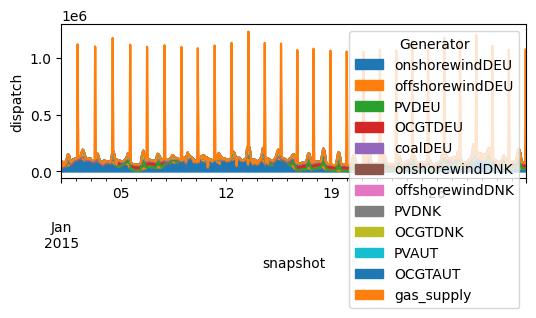

In [115]:
# co2 emissions
n.generators_t.p.loc["2015-01"].plot.area(figsize=(6, 2), ylabel="dispatch")

In [93]:
# Installed capacities (MW)
print(n.generators.p_nom_opt)


Generator
onshorewindDEU      156967.200696
offshorewindDEU          0.000000
PVDEU               241840.627002
OCGTDEU              47570.486578
coalDEU               1572.249197
onshorewindDNK       19473.188839
offshorewindDNK          0.000000
PVDNK                 2837.677570
OCGTDNK                858.746555
PVAUT                79160.499536
OCGTAUT                  0.000000
gas_supply         1000000.000000
Name: p_nom_opt, dtype: float64


In [94]:
print(n.links.p_nom_opt)


Link
heat_pump_DEU     33664.988776
CHP_DEU               0.000000
boiler_DEU       158809.415348
resistive_DEU         0.000000
heat_pump_DNK      2266.131694
CHP_DNK               0.000000
boiler_DNK        10044.109692
resistive_DNK      2048.176716
heat_pump_AUT      3599.508364
CHP_AUT               0.000000
boiler_AUT        14773.951400
resistive_AUT         0.000000
Name: p_nom_opt, dtype: float64


In [95]:
print(n.stores.e_nom_opt)


Store
gas_store    1.000000e+09
Name: e_nom_opt, dtype: float64


In [96]:
print(n.storage_units.p_nom_opt)


StorageUnit
batteryDEU    71271.651181
batteryDNK     3849.542201
hydroAUT      28105.031270
batteryAUT     2156.870634
Name: p_nom_opt, dtype: float64


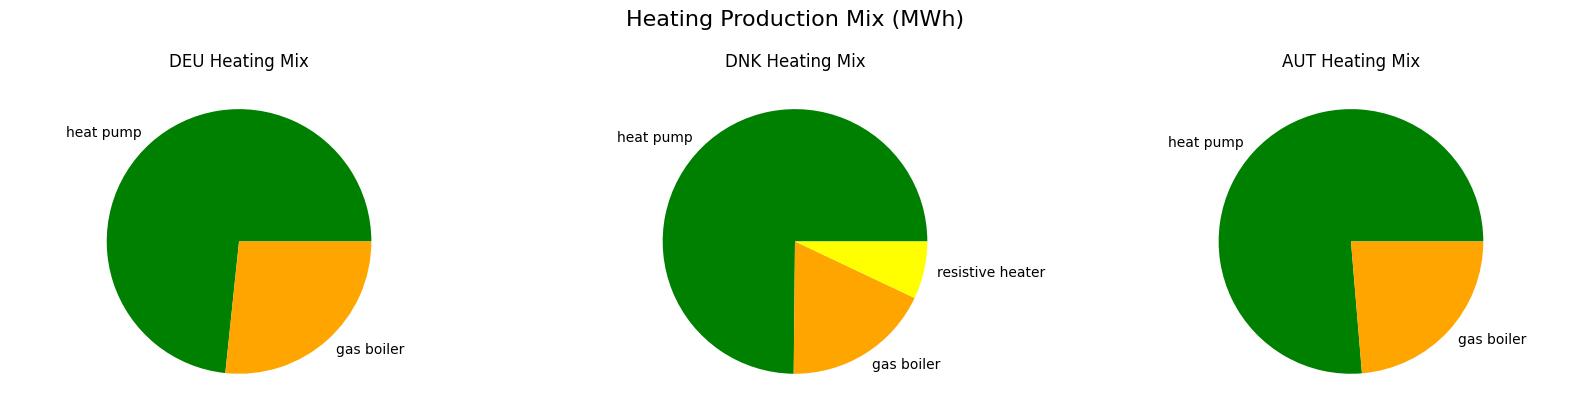

In [97]:
colors_heat = {
    'heat pump': 'green',
    'CHP (gas)': 'red',
    'gas boiler': 'orange',
    'resistive heater': 'yellow',
}

plt.figure(figsize=(16, 4))

for i, country in enumerate(countries):
    labels = []
    sizes = []

    # Heat pump output (electricity -> heat)
    hp = f'heat_pump_{country}'
    if hp in n.links.index:
        value = -n.links_t.p1[hp].sum()  # flip sign
        if value > 0.1:
            labels.append('heat pump')
            sizes.append(value)

    # CHP output (gas -> electricity + heat)
    chp = f'CHP_{country}'
    if chp in n.links.index:
        value = -n.links_t.p2[chp].sum()  # flip sign
        if value > 0.1:
            labels.append('CHP (gas)')
            sizes.append(value)

    boiler = f'boiler_{country}'
    if boiler in n.links.index:
        value = -n.links_t.p1[boiler].sum()  # flip sign
        if value > 0.1:
            labels.append('gas boiler')
            sizes.append(value)
    
    resistive = f'resistive_{country}'
    if resistive in n.links.index:
        value = -n.links_t.p1[resistive].sum()  # flip sign
        if value > 0.1:
            labels.append('resistive heater')
            sizes.append(value)

    if sizes:
        colors = [colors_heat[label] for label in labels]
        plt.subplot(1, 3, i + 1)
        plt.pie(sizes, labels=labels, colors=colors, wedgeprops={'linewidth': 0})
        plt.axis('equal')
        plt.title(f"{country} Heating Mix", y=1.07)
    else:
        plt.subplot(1, 3, i + 1)
        plt.text(0.5, 0.5, 'No heating', ha='center', va='center')
        plt.axis('off')

plt.suptitle("Heating Production Mix (MWh)", fontsize=16)
plt.tight_layout()
plt.show()


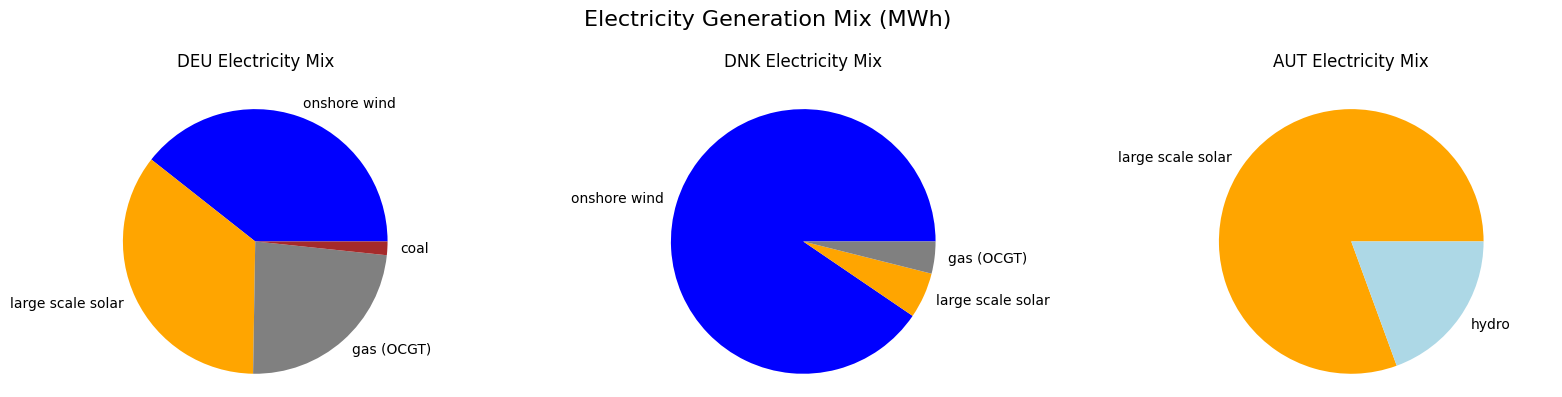

In [98]:
colors_gen = {
    'onshore wind': 'blue',
    'offshore wind': 'darkblue',
    'large scale solar': 'orange',
    'gas (OCGT)': 'grey',
    'coal': 'brown',
    'hydro': 'lightblue',
    'CHP (el)': 'red'
}

plt.figure(figsize=(16, 4))

for i, country in enumerate(countries):
    labels = []
    sizes = []

    # Onshore wind
    if f'onshorewind{country}' in n.generators.index:
        value = n.generators_t.p[f'onshorewind{country}'].sum()
        if value > 0.1:
            labels.append('onshore wind')
            sizes.append(value)

    # Offshore wind
    if f'offshorewind{country}' in n.generators.index:
        value = n.generators_t.p[f'offshorewind{country}'].sum()
        if value > 0.1:
            labels.append('offshore wind')
            sizes.append(value)

    # PV
    if f'PV{country}' in n.generators.index:
        value = n.generators_t.p[f'PV{country}'].sum()
        if value > 0.1:
            labels.append('large scale solar')
            sizes.append(value)

    # OCGT
    if f'OCGT{country}' in n.generators.index:
        value = n.generators_t.p[f'OCGT{country}'].sum()
        if value > 0.1:
            labels.append('gas (OCGT)')
            sizes.append(value)

    # Coal
    if f'coal{country}' in n.generators.index:
        value = n.generators_t.p[f'coal{country}'].sum()
        if value > 0.1:
            labels.append('coal')
            sizes.append(value)

    # Hydro (storage unit dispatch)
    if f"hydro{country}" in n.storage_units.index:
        value = n.storage_units_t.p[f"hydro{country}"].sum()
        if value > 0.1:
            labels.append('hydro')
            sizes.append(value)
    
    # CHP output electricity
    chp = f'CHP_{country}'
    if chp in n.links.index:
        value = -n.links_t.p1[chp].sum()  # el output
        if value > 0.1:
            labels.append('CHP (el)')
            sizes.append(value)


    if sizes:
        colors = [colors_gen[label] for label in labels]
        plt.subplot(1, 3, i + 1)
        plt.pie(sizes, labels=labels, colors=colors, wedgeprops={'linewidth': 0})
        plt.axis('equal')
        plt.title(f"{country} Electricity Mix", y=1.07)
    else:
        plt.subplot(1, 3, i + 1)
        plt.text(0.5, 0.5, 'No generation', ha='center', va='center')
        plt.axis('off')

plt.suptitle("Electricity Generation Mix (MWh)", fontsize=16)
plt.tight_layout()
plt.show()


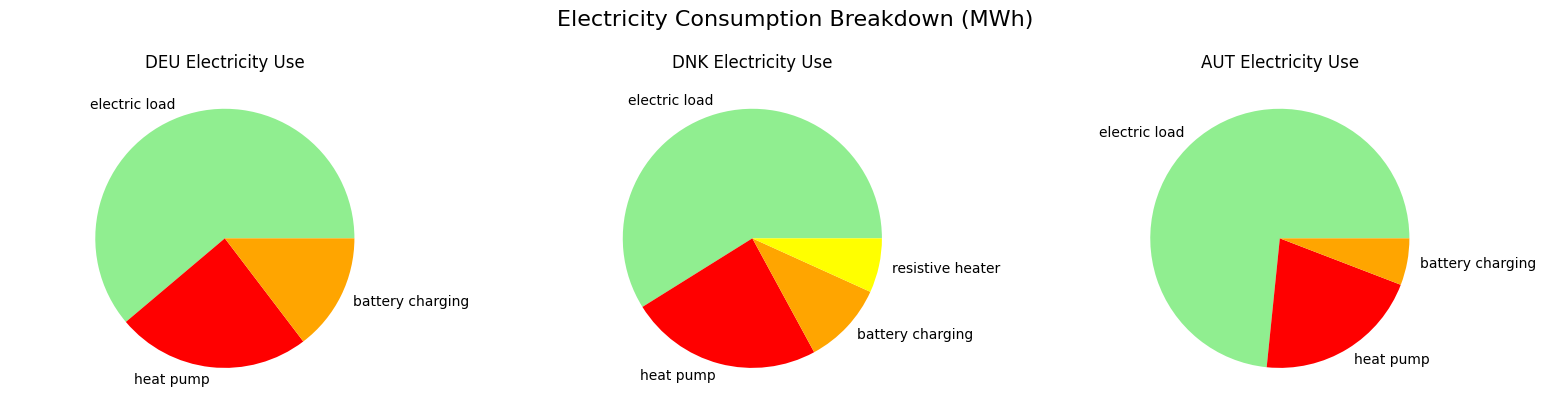

In [99]:
colors_con = {
    'electric load': 'lightgreen',
    'heat pump': 'red',
    'battery charging': 'orange',
    'resistive heater': 'yellow'
}

plt.figure(figsize=(16, 4))

for i, country in enumerate(countries):
    labels = []
    sizes = []

    # Load
    if f"load{country}" in n.loads_t.p.columns:
        val = n.loads_t.p[f"load{country}"].sum()
        if val > 0.1:
            labels.append("electric load")
            sizes.append(val)

    # Heat pump
    hp = f"heat_pump_{country}"
    if hp in n.links_t.p0.columns:
        val = n.links_t.p0[hp].sum()
        if val > 0.1:
            labels.append("heat pump")
            sizes.append(val)


    # Battery charging
    bat = f"battery{country}"
    if bat in n.storage_units_t.p.columns:
        val = -n.storage_units_t.p[bat][n.storage_units_t.p[bat] < 0].sum()
        if val > 0.1:
            labels.append("battery charging")
            sizes.append(val)

    resistive = f'resistive_{country}'
    if resistive in n.links_t.p0.columns:
        val = n.links_t.p0[resistive].sum()
        if val > 0.1:
            labels.append("resistive heater")
            sizes.append(val)

    if sizes:
        colors = [colors_con[l] for l in labels]
        plt.subplot(1, 3, i + 1)
        plt.pie(sizes, labels=labels, colors=colors, wedgeprops={'linewidth': 0})
        plt.axis('equal')
        plt.title(f"{country} Electricity Use", y=1.07)
    else:
        plt.subplot(1, 3, i + 1)
        plt.text(0.5, 0.5, 'No data', ha='center', va='center')
        plt.axis('off')

plt.suptitle("Electricity Consumption Breakdown (MWh)", fontsize=16)
plt.tight_layout()
plt.show()


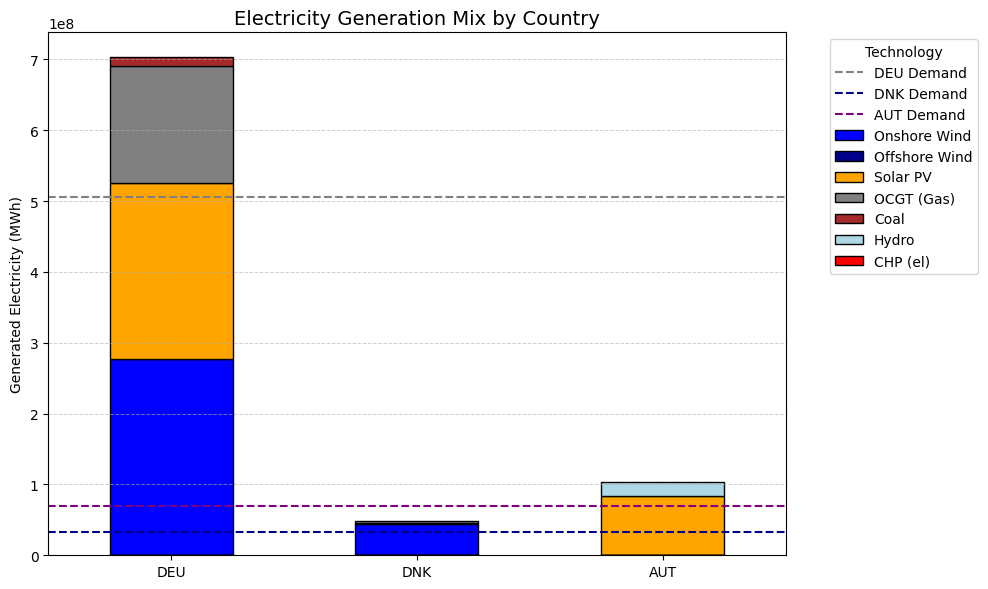

In [113]:
# Define the technologies and their labels/colors
tech_labels = {
    'onshorewind': 'Onshore Wind',
    'offshorewind': 'Offshore Wind',
    'PV': 'Solar PV',
    'OCGT': 'OCGT (Gas)',
    'coal': 'Coal',
    'hydro': 'Hydro',
    'CHP': 'CHP (el)',
}

colors = {
    'Onshore Wind': 'blue',
    'Offshore Wind': 'darkblue',
    'Solar PV': 'orange',
    'OCGT (Gas)': 'grey',
    'Coal': 'brown',
    'Hydro': 'lightblue',
    'CHP (el)': 'red',
}

# Initialize dataframe to collect generation by country and tech
df_gen = pd.DataFrame(0.0, index=tech_labels.values(), columns=countries)

for country in countries:
    for tech_key, tech_label in tech_labels.items():
        if tech_key == "hydro":
            unit_name = f"hydro{country}"
            if unit_name in n.storage_units.index:
                value = n.storage_units_t.p[unit_name].sum()
                df_gen.at[tech_label, country] = value

        elif tech_key == "CHP":
            unit_name = f"CHP_{country}"
            if unit_name in n.links.index:
                value = -n.links_t.p1[unit_name].sum()
                df_gen.at[tech_label, country] = value
        else:
            gen_name = f"{tech_key}{country}"
            if gen_name in n.generators.index:
                value = n.generators_t.p[gen_name].sum()
                df_gen.at[tech_label, country] = value

# Plot
ax = df_gen.T.plot(kind='bar', stacked=True, color=[colors[t] for t in df_gen.index],
                   figsize=(10, 6), edgecolor='black')

# Add a lineplot for electric demand 
el_demand = {"DEU":n.loads_t.p["loadDEU"].sum(),
            "DNK":n.loads_t.p["loadDNK"].sum(),
            "AUT":n.loads_t.p["loadAUT"].sum()}
#plt.plot(el_demand.keys(), el_demand.values(), color='black', label='Electricity Demand', linewidth=2, marker='o')

country_colors = {
    'DEU': 'grey',
    'DNK': 'darkblue',
    'AUT': 'purple'
}
for country, value in el_demand.items():
    # plot horizontal line for each country
    plt.axhline(y=value, linestyle='--', label=f'{country} Demand', color=country_colors[country])

plt.title("Electricity Generation Mix by Country", fontsize=14)
plt.ylabel("Generated Electricity (MWh)")
plt.xticks(rotation=0)
plt.legend(title="Technology", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
plt.tight_layout()
plt.show()


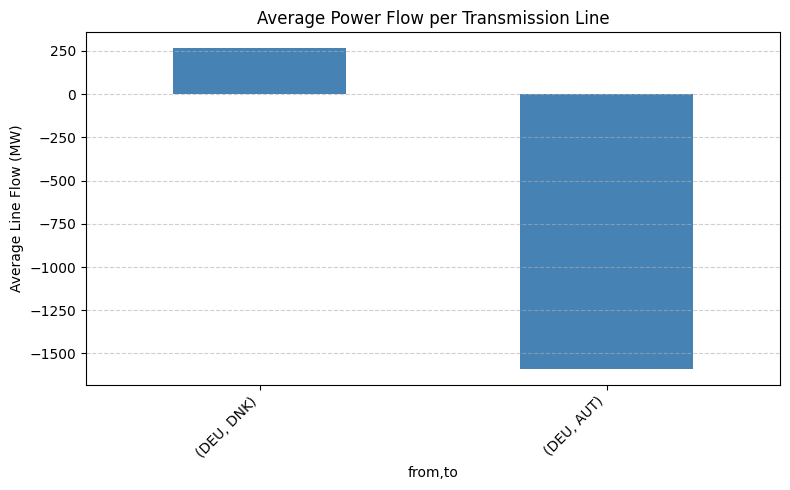

In [101]:
# Create a summary DataFrame
line_flows = pd.DataFrame(index=n.lines.index)
line_flows["from"] = n.lines.bus0
line_flows["to"] = n.lines.bus1
line_flows["average_flow_MW"] = n.lines_t.p0.mean()

# Plot as bar chart
plt.figure(figsize=(8, 5))
line_flows.set_index(["from", "to"])["average_flow_MW"].plot(kind='bar', color='steelblue')
plt.ylabel("Average Line Flow (MW)")
plt.title("Average Power Flow per Transmission Line")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

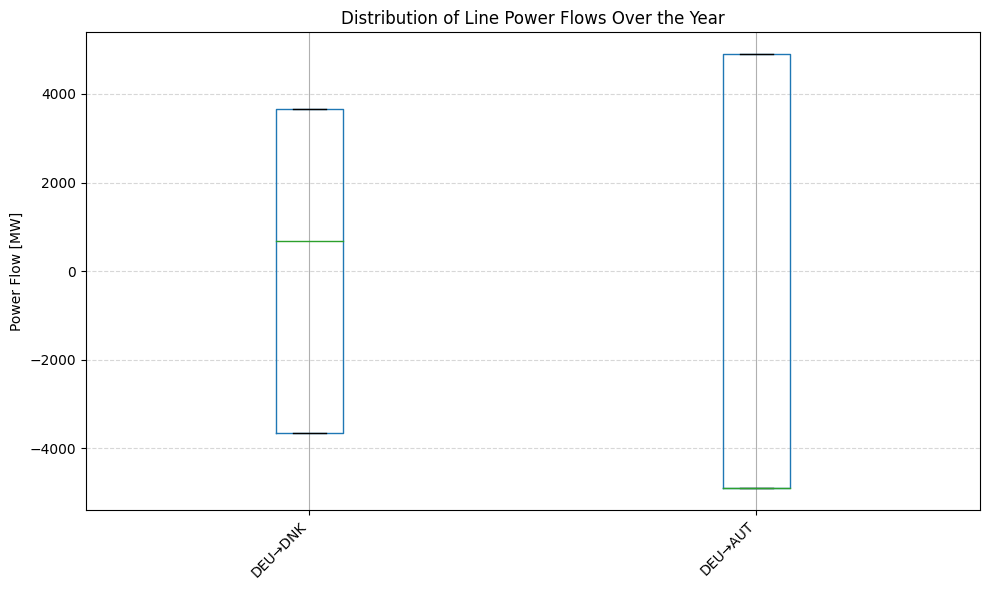

In [102]:
# Transpose so each line is a column
line_flow_data = n.lines_t.p0.copy()

# Optional: create readable labels like "DEU→DNK"
labels = [f"{n.lines.at[line, 'bus0']}→{n.lines.at[line, 'bus1']}" for line in line_flow_data.columns]
line_flow_data.columns = labels

# Plot boxplot
plt.figure(figsize=(10, 6))
line_flow_data.boxplot()
plt.title("Distribution of Line Power Flows Over the Year")
plt.ylabel("Power Flow [MW]")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

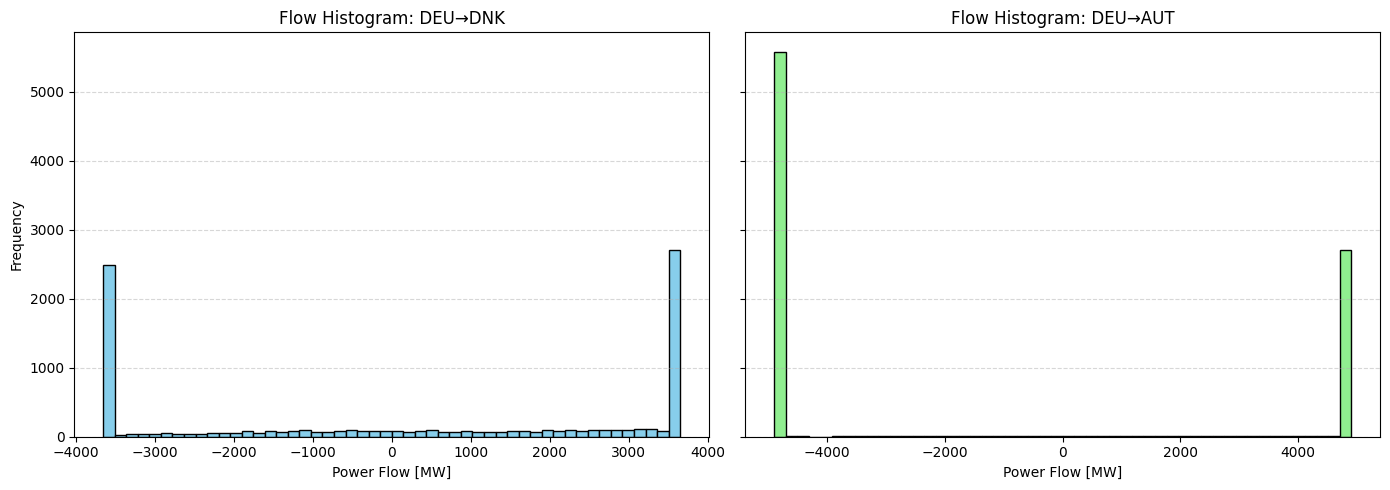

In [110]:
import matplotlib.pyplot as plt

# Choose two line IDs (adjust based on your network)
line1_id = 'DEU-DNK'
line2_id = 'DEU-AUT'

# Create readable names
line1_name = f"{n.lines.at[line1_id, 'bus0']}→{n.lines.at[line1_id, 'bus1']}"
line2_name = f"{n.lines.at[line2_id, 'bus0']}→{n.lines.at[line2_id, 'bus1']}"

# Get power flow time series
flow1 = n.lines_t.p0[line1_id]
flow2 = n.lines_t.p0[line2_id]

# Plot both histograms side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].hist(flow1, bins=50, color='skyblue', edgecolor='black')
axes[0].set_title(f"Flow Histogram: {line1_name}")
axes[0].set_xlabel("Power Flow [MW]")
axes[0].set_ylabel("Frequency")
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

axes[1].hist(flow2, bins=50, color='lightgreen', edgecolor='black')
axes[1].set_title(f"Flow Histogram: {line2_name}")
axes[1].set_xlabel("Power Flow [MW]")
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


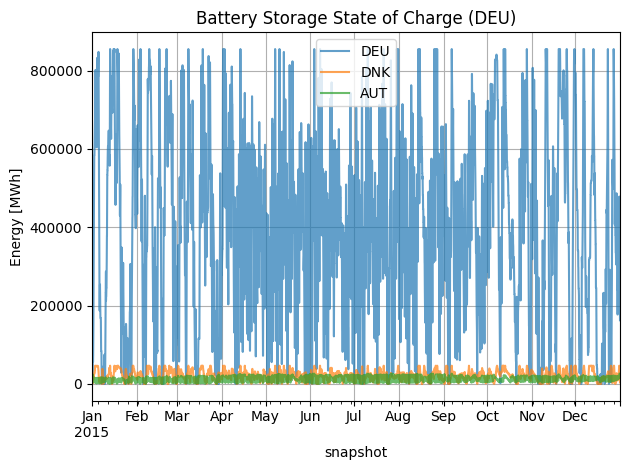

In [103]:
for country in countries:
    name = f"battery{country}"
    if name in n.storage_units_t.state_of_charge:
        n.storage_units_t.state_of_charge[name].plot(label=country, alpha=0.7)
plt.title("Battery Storage State of Charge (DEU)")
plt.ylabel("Energy [MWh]")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


In [104]:
colors = {
    'onshore wind': 'blue',
    'offshore wind': 'darkblue',
    'large scale solar': 'orange',
    'gas (OCGT)': 'grey',
    'coal': 'brown',
    'hydro': 'lightblue',
    'CHP (el)': 'red',
    'H2 Fuel Cell': 'pink'
}

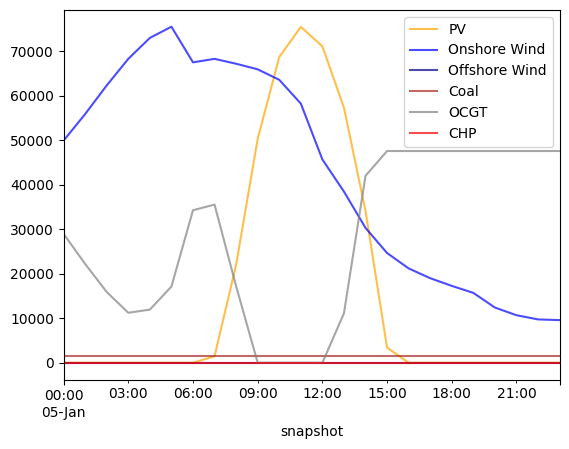

In [105]:
day = "2015-01-05"

# plot generation and consumption in one country for the specific day
country = "DEU"
n.generators_t.p[f"PV{country}"].loc[day].plot(label="PV", color=colors["large scale solar"], alpha=0.7)
n.generators_t.p[f"onshorewind{country}"].loc[day].plot(label="Onshore Wind", color=colors["onshore wind"], alpha=0.7)
n.generators_t.p[f"offshorewind{country}"].loc[day].plot(label="Offshore Wind", color=colors["offshore wind"], alpha=0.7)
n.generators_t.p[f"coal{country}"].loc[day].plot(label="Coal", color=colors["coal"], alpha=0.7)
n.generators_t.p[f"OCGT{country}"].loc[day].plot(label="OCGT", color=colors["gas (OCGT)"], alpha=0.7)
(-n.links_t.p1[f"CHP_{country}"].loc[day]).plot(label="CHP", color=colors["CHP (el)"], alpha=0.7)
plt.legend()

plt.show()
